In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/music-dataset/train_music.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
sns.set(rc = {'figure.figsize':(10, 8)}) # более красивый внешний вид графиков по умолчанию

In [3]:
df = pd.read_csv("../input/music-dataset/train_music.csv", encoding = "ISO-8859-1")
df.head().T #для удобства транспонируем таблицу, т.к. признаков очень много

,0,1,2,3,4
id,4.810491e+10,4.851497e+09,4.877823e+09,4.830184e+09,4.810394e+10
target,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
device_type,7.000000e+00,4.000000e+00,7.000000e+00,7.000000e+00,4.000000e+00
manufacturer_category,1.514000e+03,8.960000e+02,5.920000e+02,1.756000e+03,1.057000e+03
os_category,3.000000e+00,2.800000e+01,3.000000e+00,3.000000e+00,2.800000e+01
...,...,...,...,...,...
income_brnd_cont_m3,NaN,NaN,NaN,NaN,NaN
data_type_1_m3,NaN,NaN,NaN,NaN,NaN
data_type_2_m3,1.376232e+04,NaN,NaN,NaN,NaN
data_type_3_m3,1.292469e+03,5.340576e-05,9.765625e-04,6.680489e-03,2.487183e-03


#  Предобработка данных 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 461 entries, id to service_9_flag_m3
dtypes: float64(452), int64(9)
memory usage: 246.2 MB


In [5]:
df.isnull().sum()#приблизительно посмотрим сколько всего пустых значений в каждом столбце

id                           0
target                       0
device_type                  0
manufacturer_category        0
os_category                  0
                         ...  
income_brnd_cont_m3      60767
data_type_1_m3           61970
data_type_2_m3           25618
data_type_3_m3           20028
service_9_flag_m3        66351
Length: 461, dtype: int64

In [6]:
#удалим столбцы в которых кол-во не пустых элементов меньше 50000
df.dropna(axis=1, thresh=50000, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 381 entries, id to service_8_count_m3
dtypes: float64(372), int64(9)
memory usage: 203.5 MB


In [7]:
#удалим строки в которых кол-во не пустых элементов меньше 250
df.dropna(axis=0, thresh=250, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66985 entries, 0 to 69999
Columns: 381 entries, id to service_8_count_m3
dtypes: float64(372), int64(9)
memory usage: 195.2 MB


In [8]:
df.isnull().sum()#Посмотрим сколько теперь осталось nan

id                          0
target                      0
device_type                 0
manufacturer_category       0
os_category                 0
                         ... 
service_5_count_m3          0
service_6_count_m3          0
service_7_cost_m3        1420
service_7_flag_m3        1420
service_8_count_m3       1420
Length: 381, dtype: int64

In [9]:
df1 = df.fillna(0)
df1

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,sms_onnet_out_pack_count_m3,sms_omo_out_pack_count_m3,sms_roam_out_count_m3,sms_roam_in_count_m3,content_count_m3,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3
0,48104912810,0,7,1514,3,1.0,0,0.496508,0,299.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4851497268,0,4,896,28,1.0,0,0.881540,0,189.0,...,0.0,0.0,0.0,0.0,21.0,11.0,0.0,0.0,0.0,0.0
2,4877823097,0,7,592,3,2.0,0,0.811192,0,347.0,...,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0
3,4830183791,0,7,1756,3,2.0,0,0.928449,1,343.0,...,0.0,0.0,0.0,0.0,16.0,66.0,0.0,0.0,0.0,0.0
4,48103940036,0,4,1057,28,1.0,0,0.578654,0,355.0,...,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,4819141039,0,7,812,3,2.0,0,0.963514,0,357.0,...,0.0,0.0,0.0,0.0,108.0,65.0,0.0,0.0,0.0,0.0
69996,4888452526,0,7,1057,3,1.0,1,0.777850,0,364.0,...,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0
69997,4812460312,0,7,745,3,2.0,0,0.980984,0,363.0,...,0.0,0.0,0.0,0.0,32.0,54.0,0.0,0.0,0.0,0.0
69998,4890036665,0,7,56,3,1.0,0,0.770969,0,341.0,...,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df1.isnull().sum()#как видим все nan заменились на нули

id                       0
target                   0
device_type              0
manufacturer_category    0
os_category              0
                        ..
service_5_count_m3       0
service_6_count_m3       0
service_7_cost_m3        0
service_7_flag_m3        0
service_8_count_m3       0
Length: 381, dtype: int64

In [11]:
arr = df1.corr()['target']#считаем корреляцию между всеми признаками и таргетом

In [12]:
print(arr)

id                       0.152440
target                   1.000000
device_type              0.024298
manufacturer_category    0.003639
os_category             -0.042627
                           ...   
service_5_count_m3      -0.005981
service_6_count_m3       0.014828
service_7_cost_m3        0.036892
service_7_flag_m3        0.041282
service_8_count_m3            NaN
Name: target, Length: 381, dtype: float64


In [13]:
for i in arr:
    print(i)

0.15244007364845222
1.0
0.024297807524607612
0.0036387019419602913
-0.042626910101756926
-0.003740365222275377
-0.03599389317958241
-0.19766711408105345
-0.02601904061399409
0.0037133267223403658
-0.0318614093940681
-0.04177360156335644
nan
-0.03341786137593348
-0.04087889060854527
-0.026090560611068972
-0.022848409699047282
0.008997620854120987
nan
-0.0051464356430494535
0.001520884596459292
-0.028340787174446613
-0.022785041167304315
-0.048605091131991164
-0.01609902394985668
-0.004040896435487922
-0.009432367482527496
-0.010582662684337028
0.0024247523405553106
-0.012262845245976022
0.005667179842417681
-0.010705710178248997
-0.0153942717765472
-0.029121159433363054
0.0006539737702249491
0.006202677758597003
nan
-0.03282898371122669
-0.02509403324398683
-0.0184755233941666
-0.0066299182468689535
0.056612969103907465
0.04679681277359605
-0.0036762423414020426
0.013865340320197454
-0.0007231992410005546
0.04502480328038322
-0.016859898973500938
-0.02458300333724329
0.01114243764810406

In [14]:
#df2 != 0 - логическое значение, которое истинно, если df2 не равно нулю
#(df2 != 0).any(axis=0) - количество столбцов с ненулевыми записями
#any - агрегирует значения по строкам в одно логическое значение, т.е.
#в результате имеем одно значение да/нет для каждого столбца
#df2.loc - выбирает это столбцы

df1 = df1.loc[:, (df1 != 0).any(axis=0)]#удаляем нулевые столбцы
df1

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,sms_out_count_m3,sms_in_count_m3,sms_onnet_out_pack_count_m3,sms_omo_out_pack_count_m3,sms_roam_out_count_m3,content_count_m3,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3
0,48104912810,0,7,1514,3,1.0,0,0.496508,0,299.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4851497268,0,4,896,28,1.0,0,0.881540,0,189.0,...,0.0,6.0,0.0,0.0,0.0,21.0,11.0,0.0,0.0,0.0
2,4877823097,0,7,592,3,2.0,0,0.811192,0,347.0,...,1.0,32.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0
3,4830183791,0,7,1756,3,2.0,0,0.928449,1,343.0,...,3.0,62.0,0.0,0.0,0.0,16.0,66.0,0.0,0.0,0.0
4,48103940036,0,4,1057,28,1.0,0,0.578654,0,355.0,...,0.0,72.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,4819141039,0,7,812,3,2.0,0,0.963514,0,357.0,...,17.0,27.0,0.0,0.0,0.0,108.0,65.0,0.0,0.0,0.0
69996,4888452526,0,7,1057,3,1.0,1,0.777850,0,364.0,...,3.0,4.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
69997,4812460312,0,7,745,3,2.0,0,0.980984,0,363.0,...,3.0,7.0,0.0,0.0,0.0,32.0,54.0,0.0,0.0,0.0
69998,4890036665,0,7,56,3,1.0,0,0.770969,0,341.0,...,1.0,4.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0


In [15]:
arr1 = df1.corr()['target']# еще раз пересчитаем корреляцию после того как удалили все нулевые столбцы
print(len(arr1))

368


In [16]:
type(arr1)
# как видим, мы получили тип данных series 
# преобразуем это в list чтобы было удобно дообавить в наш датасет

pandas.core.series.Series

In [17]:
arr_final=arr1.tolist()#преобразуем в list чтобы удобнее было добавлять в датасет
print(type(arr_final))

<class 'list'>


In [18]:
df1.loc['70000']=arr_final#добавим значения корреляций как последнюю строку
df1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,sms_out_count_m3,sms_in_count_m3,sms_onnet_out_pack_count_m3,sms_omo_out_pack_count_m3,sms_roam_out_count_m3,content_count_m3,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3
0,4.810491e+10,0.0,7.000000,1514.000000,3.000000,1.00000,0.000000,0.496508,0.000000,299.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.851497e+09,0.0,4.000000,896.000000,28.000000,1.00000,0.000000,0.881540,0.000000,189.000000,...,0.000000,6.000000,0.000000,0.000000,0.000000,21.000000,11.000000,0.000000,0.000000,0.000000
2,4.877823e+09,0.0,7.000000,592.000000,3.000000,2.00000,0.000000,0.811192,0.000000,347.000000,...,1.000000,32.000000,0.000000,0.000000,0.000000,74.000000,0.000000,0.000000,0.000000,0.000000
3,4.830184e+09,0.0,7.000000,1756.000000,3.000000,2.00000,0.000000,0.928449,1.000000,343.000000,...,3.000000,62.000000,0.000000,0.000000,0.000000,16.000000,66.000000,0.000000,0.000000,0.000000
4,4.810394e+10,0.0,4.000000,1057.000000,28.000000,1.00000,0.000000,0.578654,0.000000,355.000000,...,0.000000,72.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69996,4.888453e+09,0.0,7.000000,1057.000000,3.000000,1.00000,1.000000,0.777850,0.000000,364.000000,...,3.000000,4.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000
69997,4.812460e+09,0.0,7.000000,745.000000,3.000000,2.00000,0.000000,0.980984,0.000000,363.000000,...,3.000000,7.000000,0.000000,0.000000,0.000000,32.000000,54.000000,0.000000,0.000000,0.000000
69998,4.890037e+09,0.0,7.000000,56.000000,3.000000,1.00000,0.000000,0.770969,0.000000,341.000000,...,1.000000,4.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000
69999,4.812920e+09,0.0,7.000000,69.000000,27.000000,1.00000,0.000000,0.951170,0.000000,364.000000,...,1.000000,80.000000,0.000000,0.000000,0.000000,161.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
df1.dropna(axis=1, how='any', inplace=True)#убираем столбцы с корреляцией nan
df1

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,sms_out_count_m3,sms_in_count_m3,sms_onnet_out_pack_count_m3,sms_omo_out_pack_count_m3,sms_roam_out_count_m3,content_count_m3,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3
0,4.810491e+10,0.0,7.000000,1514.000000,3.000000,1.00000,0.000000,0.496508,0.000000,299.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.851497e+09,0.0,4.000000,896.000000,28.000000,1.00000,0.000000,0.881540,0.000000,189.000000,...,0.000000,6.000000,0.000000,0.000000,0.000000,21.000000,11.000000,0.000000,0.000000,0.000000
2,4.877823e+09,0.0,7.000000,592.000000,3.000000,2.00000,0.000000,0.811192,0.000000,347.000000,...,1.000000,32.000000,0.000000,0.000000,0.000000,74.000000,0.000000,0.000000,0.000000,0.000000
3,4.830184e+09,0.0,7.000000,1756.000000,3.000000,2.00000,0.000000,0.928449,1.000000,343.000000,...,3.000000,62.000000,0.000000,0.000000,0.000000,16.000000,66.000000,0.000000,0.000000,0.000000
4,4.810394e+10,0.0,4.000000,1057.000000,28.000000,1.00000,0.000000,0.578654,0.000000,355.000000,...,0.000000,72.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69996,4.888453e+09,0.0,7.000000,1057.000000,3.000000,1.00000,1.000000,0.777850,0.000000,364.000000,...,3.000000,4.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000
69997,4.812460e+09,0.0,7.000000,745.000000,3.000000,2.00000,0.000000,0.980984,0.000000,363.000000,...,3.000000,7.000000,0.000000,0.000000,0.000000,32.000000,54.000000,0.000000,0.000000,0.000000
69998,4.890037e+09,0.0,7.000000,56.000000,3.000000,1.00000,0.000000,0.770969,0.000000,341.000000,...,1.000000,4.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000
69999,4.812920e+09,0.0,7.000000,69.000000,27.000000,1.00000,0.000000,0.951170,0.000000,364.000000,...,1.000000,80.000000,0.000000,0.000000,0.000000,161.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
df_sorted = df1.sort_values(by=df1.index[-1], ascending=True, axis=1)
#сортируем столбцы датасета по значениям последней строки, то есть по значениям корреляций
df_sorted

,lt,count_sms_source_5,voice_onnet_out_day_work_dur_m3,os_category,voice_onnet_in_day_work_dur_m3,service_1_count,is_obl_center,voice_onnet_out_day_work_dur_m2,voice_onnet_out_day_work_count_m3,tp_flag,...,paym_count_m2,paym_el_count_m1,data_type_2_m1,all_cost_m1,paym_count_m1,content_count_m2,content_count_m3,content_count_m1,id,target
0,0.496508,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,218.310578,43.920800,0.000000,31.000000,0.000000,23.000000,4.810491e+10,0.0
1,0.881540,1.000000,60.000000,28.000000,125.000000,58.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,21.000000,30.000000,4.851497e+09,0.0
2,0.811192,1.000000,780.000000,3.000000,3946.000000,0.000000,0.000000,1920.000000,10.000000,0.000000,...,2.000000,2.000000,3557.724354,29.823000,2.000000,59.000000,74.000000,52.000000,4.877823e+09,0.0
3,0.928449,1.000000,8160.000000,3.000000,10717.000000,418.000000,1.000000,5160.000000,49.000000,0.000000,...,2.000000,1.000000,0.000000,28.399800,1.000000,23.000000,16.000000,32.000000,4.830184e+09,0.0
4,0.578654,0.000000,27600.000000,28.000000,13158.000000,0.000000,1.000000,19740.000000,252.000000,0.000000,...,2.000000,1.000000,0.000000,25.881700,1.000000,82.000000,70.000000,65.000000,4.810394e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69996,0.777850,1.000000,4920.000000,3.000000,3924.000000,0.000000,0.000000,3300.000000,26.000000,1.000000,...,1.000000,2.000000,0.000000,70.587100,2.000000,42.000000,31.000000,41.000000,4.888453e+09,0.0
69997,0.980984,1.000000,3120.000000,3.000000,1531.000000,198.000000,1.000000,1860.000000,24.000000,0.000000,...,0.000000,1.000000,0.000000,43.921400,1.000000,52.000000,32.000000,51.000000,4.812460e+09,0.0
69998,0.770969,0.000000,2520.000000,3.000000,1246.000000,0.000000,0.000000,3240.000000,34.000000,0.000000,...,2.000000,1.000000,2244.925154,47.058800,1.000000,54.000000,34.000000,36.000000,4.890037e+09,0.0
69999,0.951170,4.000000,16260.000000,27.000000,8109.000000,0.000000,0.000000,15300.000000,198.000000,0.000000,...,10.000000,4.000000,187.856458,89.803800,4.000000,265.000000,161.000000,273.000000,4.812920e+09,0.0


In [21]:
#теперь отсортируем изначально полученный массив корреляций, чтобы рассчитать с какого столбца удалят ьчасть таблицы
#с низкими значениями корреляций
arrn = sorted(arr_final)
arrn.pop(-4)
arrn.pop(-4)
tmp=0
arr_new = sorted(arrn)
#print(arr_new)
for i in range(0, 355, 1):
    if arr_new[i]>0.02:
        tmp+=1
        #print(i)
print(tmp)
print(arr_new[210])

90
0.01000853619865805


In [22]:
for i in range(0, 266, 1):
    df_new = df_sorted.drop(df_sorted.columns[:i], axis=1)
df_new

,voice_omo_in_day_rest_count_m3,service_6_count_m1,voice_omo_in_day_rest_count_m2,voice_omo_out_night_rest_dur_m3,service_6_count_m2,all_count_m2,voice_omo_out_cost_m2,voice_onnet_out_night_work_cost_m1,voice_omo_out_night_work_dur_m3,sms_out_count_m1,...,paym_count_m2,paym_el_count_m1,data_type_2_m1,all_cost_m1,paym_count_m1,content_count_m2,content_count_m3,content_count_m1,id,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,137.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,218.310578,43.920800,0.000000,31.000000,0.000000,23.000000,4.810491e+10,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,1.176400,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,21.000000,30.000000,4.851497e+09,0.0
2,1.000000,0.000000,1.000000,0.000000,0.000000,238.000000,1.724800,2.352900,660.000000,1.000000,...,2.000000,2.000000,3557.724354,29.823000,2.000000,59.000000,74.000000,52.000000,4.877823e+09,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,0.000000,0.000000,0.000000,4.000000,...,2.000000,1.000000,0.000000,28.399800,1.000000,23.000000,16.000000,32.000000,4.830184e+09,0.0
4,4.000000,0.000000,1.000000,0.000000,0.000000,1168.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,25.881700,1.000000,82.000000,70.000000,65.000000,4.810394e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69996,0.000000,0.000000,0.000000,0.000000,0.000000,128.000000,0.000000,3.921500,0.000000,7.000000,...,1.000000,2.000000,0.000000,70.587100,2.000000,42.000000,31.000000,41.000000,4.888453e+09,0.0
69997,0.000000,0.000000,0.000000,0.000000,1.000000,98.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,1.000000,0.000000,43.921400,1.000000,52.000000,32.000000,51.000000,4.812460e+09,0.0
69998,0.000000,0.000000,0.000000,0.000000,0.000000,336.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,1.000000,2244.925154,47.058800,1.000000,54.000000,34.000000,36.000000,4.890037e+09,0.0
69999,0.000000,0.000000,7.000000,0.000000,0.000000,1234.000000,14.903000,11.764500,960.000000,2.000000,...,10.000000,4.000000,187.856458,89.803800,4.000000,265.000000,161.000000,273.000000,4.812920e+09,0.0


In [23]:
df_new1 = df_new.drop('70000') 
df_new1

,voice_omo_in_day_rest_count_m3,service_6_count_m1,voice_omo_in_day_rest_count_m2,voice_omo_out_night_rest_dur_m3,service_6_count_m2,all_count_m2,voice_omo_out_cost_m2,voice_onnet_out_night_work_cost_m1,voice_omo_out_night_work_dur_m3,sms_out_count_m1,...,paym_count_m2,paym_el_count_m1,data_type_2_m1,all_cost_m1,paym_count_m1,content_count_m2,content_count_m3,content_count_m1,id,target
0,0.0,0.0,0.0,0.0,0.0,137.0,0.0000,0.0000,0.0,0.0,...,0.0,0.0,218.310578,43.9208,0.0,31.0,0.0,23.0,4.810491e+10,0.0
1,0.0,0.0,0.0,0.0,0.0,32.0,1.1764,0.0000,0.0,0.0,...,0.0,0.0,0.000000,0.0000,0.0,28.0,21.0,30.0,4.851497e+09,0.0
2,1.0,0.0,1.0,0.0,0.0,238.0,1.7248,2.3529,660.0,1.0,...,2.0,2.0,3557.724354,29.8230,2.0,59.0,74.0,52.0,4.877823e+09,0.0
3,0.0,0.0,0.0,0.0,0.0,157.0,0.0000,0.0000,0.0,4.0,...,2.0,1.0,0.000000,28.3998,1.0,23.0,16.0,32.0,4.830184e+09,0.0
4,4.0,0.0,1.0,0.0,0.0,1168.0,0.0000,0.0000,0.0,0.0,...,2.0,1.0,0.000000,25.8817,1.0,82.0,70.0,65.0,4.810394e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,681.0,0.0000,0.0000,0.0,62.0,...,3.0,1.0,555.004056,50.5877,1.0,129.0,108.0,138.0,4.819141e+09,0.0
69996,0.0,0.0,0.0,0.0,0.0,128.0,0.0000,3.9215,0.0,7.0,...,1.0,2.0,0.000000,70.5871,2.0,42.0,31.0,41.0,4.888453e+09,0.0
69997,0.0,0.0,0.0,0.0,1.0,98.0,0.0000,0.0000,0.0,4.0,...,0.0,1.0,0.000000,43.9214,1.0,52.0,32.0,51.0,4.812460e+09,0.0
69998,0.0,0.0,0.0,0.0,0.0,336.0,0.0000,0.0000,0.0,1.0,...,2.0,1.0,2244.925154,47.0588,1.0,54.0,34.0,36.0,4.890037e+09,0.0


In [24]:
corr_matrix = df_new1.corr()#создаем матрицу корреляций

# отбираем верхний треугольник матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# находим признаки с корреляцией больше 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# удаляем эти признаки 
df_new2 = df_new1.drop(to_drop, axis=1)
df_new2

,voice_omo_in_day_rest_count_m3,service_6_count_m1,voice_omo_in_day_rest_count_m2,voice_omo_out_night_rest_dur_m3,service_6_count_m2,all_count_m2,voice_omo_out_cost_m2,voice_onnet_out_night_work_cost_m1,voice_omo_out_night_work_dur_m3,sms_out_count_m1,...,all_cost_m2,data_type_3_m1,paym_el_count_m1,data_type_2_m1,all_cost_m1,content_count_m2,content_count_m3,content_count_m1,id,target
0,0.0,0.0,0.0,0.0,0.0,137.0,0.0000,0.0000,0.0,0.0,...,21.9604,0.023283,0.0,218.310578,43.9208,31.0,0.0,23.0,4.810491e+10,0.0
1,0.0,0.0,0.0,0.0,0.0,32.0,1.1764,0.0000,0.0,0.0,...,1.1764,0.000000,0.0,0.000000,0.0000,28.0,21.0,30.0,4.851497e+09,0.0
2,1.0,0.0,1.0,0.0,0.0,238.0,1.7248,2.3529,660.0,1.0,...,42.5966,103.749401,2.0,3557.724354,29.8230,59.0,74.0,52.0,4.877823e+09,0.0
3,0.0,0.0,0.0,0.0,0.0,157.0,0.0000,0.0000,0.0,4.0,...,27.6155,0.000000,1.0,0.000000,28.3998,23.0,16.0,32.0,4.830184e+09,0.0
4,4.0,0.0,1.0,0.0,0.0,1168.0,0.0000,0.0000,0.0,0.0,...,46.6658,0.005238,1.0,0.000000,25.8817,82.0,70.0,65.0,4.810394e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,681.0,0.0000,0.0000,0.0,62.0,...,47.0588,24.243153,1.0,555.004056,50.5877,129.0,108.0,138.0,4.819141e+09,0.0
69996,0.0,0.0,0.0,0.0,0.0,128.0,0.0000,3.9215,0.0,7.0,...,0.0000,0.000000,2.0,0.000000,70.5871,42.0,31.0,41.0,4.888453e+09,0.0
69997,0.0,0.0,0.0,0.0,1.0,98.0,0.0000,0.0000,0.0,4.0,...,0.0000,0.000000,1.0,0.000000,43.9214,52.0,32.0,51.0,4.812460e+09,0.0
69998,0.0,0.0,0.0,0.0,0.0,336.0,0.0000,0.0000,0.0,1.0,...,90.1960,25.277548,1.0,2244.925154,47.0588,54.0,34.0,36.0,4.890037e+09,0.0


In [25]:
print(df_new2.columns.tolist())
#выведем список оставшихся столбцов чтобы вручную проанализировать их актуальность

['voice_omo_in_day_rest_count_m3', 'service_6_count_m1', 'voice_omo_in_day_rest_count_m2', 'voice_omo_out_night_rest_dur_m3', 'service_6_count_m2', 'all_count_m2', 'voice_omo_out_cost_m2', 'voice_onnet_out_night_work_cost_m1', 'voice_omo_out_night_work_dur_m3', 'sms_out_count_m1', 'voice_omo_out_night_rest_cost_m3', 'com_num_cost_m3', 'voice_onnet_in_night_work_count_m1', 'voice_omo_out_cost_m1', 'paym_el_sum_m3', 'voice_omo_out_dur_m1', 'voice_omo_out_dur_m2', 'voice_onnet_out_night_work_cost_m3', 'voice_omo_out_day_rest_count_m3', 'voice_omo_out_count_m3', 'voice_omo_out_day_rest_cost_m2', 'voice_onnet_in_night_rest_count_m1', 'voice_omo_out_night_work_dur_m2', 'device_type', 'sms_cost_m2', 'sms_out_count_m3', 'voice_omo_out_night_rest_cost_m2', 'paym_el_sum_m2', 'all_count_m1', 'voice_omo_out_night_rest_dur_m2', 'voice_omo_out_day_rest_dur_m2', 'voice_omo_in_day_rest_count_m1', 'com_num_cost_m2', 'voice_omo_out_day_rest_cost_m1', 'content_cost_m2', 'voice_omo_out_night_work_dur_m1',

In [26]:
df_new3 = df_new2.drop('id', axis = 1)#удалим столбец индекс, т.к. он не имет никакого значения
df_new3

,voice_omo_in_day_rest_count_m3,service_6_count_m1,voice_omo_in_day_rest_count_m2,voice_omo_out_night_rest_dur_m3,service_6_count_m2,all_count_m2,voice_omo_out_cost_m2,voice_onnet_out_night_work_cost_m1,voice_omo_out_night_work_dur_m3,sms_out_count_m1,...,all_home_clc_m2,all_cost_m2,data_type_3_m1,paym_el_count_m1,data_type_2_m1,all_cost_m1,content_count_m2,content_count_m3,content_count_m1,target
0,0.0,0.0,0.0,0.0,0.0,137.0,0.0000,0.0000,0.0,0.0,...,0.0000,21.9604,0.023283,0.0,218.310578,43.9208,31.0,0.0,23.0,0.0
1,0.0,0.0,0.0,0.0,0.0,32.0,1.1764,0.0000,0.0,0.0,...,1.1764,1.1764,0.000000,0.0,0.000000,0.0000,28.0,21.0,30.0,0.0
2,1.0,0.0,1.0,0.0,0.0,238.0,1.7248,2.3529,660.0,1.0,...,13.6461,42.5966,103.749401,2.0,3557.724354,29.8230,59.0,74.0,52.0,0.0
3,0.0,0.0,0.0,0.0,0.0,157.0,0.0000,0.0000,0.0,4.0,...,2.5176,27.6155,0.000000,1.0,0.000000,28.3998,23.0,16.0,32.0,0.0
4,4.0,0.0,1.0,0.0,0.0,1168.0,0.0000,0.0000,0.0,0.0,...,8.2345,46.6658,0.005238,1.0,0.000000,25.8817,82.0,70.0,65.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,681.0,0.0000,0.0000,0.0,62.0,...,0.0000,47.0588,24.243153,1.0,555.004056,50.5877,129.0,108.0,138.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,128.0,0.0000,3.9215,0.0,7.0,...,0.0000,0.0000,0.000000,2.0,0.000000,70.5871,42.0,31.0,41.0,0.0
69997,0.0,0.0,0.0,0.0,1.0,98.0,0.0000,0.0000,0.0,4.0,...,0.0000,0.0000,0.000000,1.0,0.000000,43.9214,52.0,32.0,51.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,336.0,0.0000,0.0000,0.0,1.0,...,0.0000,90.1960,25.277548,1.0,2244.925154,47.0588,54.0,34.0,36.0,0.0


In [27]:
df_final=df_new3.sample(n=10000, random_state=42)#отберем 10000 строк, для удобства работы с массивом
df_final

,voice_omo_in_day_rest_count_m3,service_6_count_m1,voice_omo_in_day_rest_count_m2,voice_omo_out_night_rest_dur_m3,service_6_count_m2,all_count_m2,voice_omo_out_cost_m2,voice_onnet_out_night_work_cost_m1,voice_omo_out_night_work_dur_m3,sms_out_count_m1,...,all_home_clc_m2,all_cost_m2,data_type_3_m1,paym_el_count_m1,data_type_2_m1,all_cost_m1,content_count_m2,content_count_m3,content_count_m1,target
58448,0.0,0.0,2.0,0.0,0.0,469.0,0.0000,3.9215,0.0,6.0,...,0.0000,3.9215,466.493528,1.0,2309.685785,31.0270,85.0,69.0,70.0,0.0
42185,0.0,0.0,0.0,0.0,0.0,80.0,0.0000,0.0000,0.0,0.0,...,6.7449,89.0977,0.000000,1.0,0.000000,8.6270,37.0,31.0,20.0,0.0
22479,1.0,0.0,0.0,0.0,0.0,113.0,0.0000,0.0000,0.0,1.0,...,0.0000,0.0000,367.896420,1.0,1459.259577,3.9216,50.0,47.0,50.0,0.0
39290,6.0,0.0,14.0,60.0,0.0,763.0,14.0871,0.0000,360.0,7.0,...,14.0871,142.7148,779.592412,6.0,1747.196139,87.0276,101.0,51.0,69.0,0.0
39974,4.0,0.0,10.0,840.0,0.0,888.0,1.1763,0.0000,900.0,22.0,...,1.1763,1.1763,0.399587,1.0,5917.894601,74.8986,283.0,291.0,308.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25059,0.0,1.0,0.0,0.0,1.0,126.0,0.0000,0.0000,0.0,2.0,...,0.0000,43.1372,132.413796,3.0,324.264423,113.7254,8.0,27.0,35.0,0.0
35242,3.0,0.0,3.0,0.0,0.0,767.0,0.0000,0.0000,420.0,5.0,...,0.0000,0.0000,618.875447,0.0,605.809043,0.0000,41.0,58.0,53.0,0.0
6214,2.0,0.0,5.0,300.0,0.0,1777.0,4.7060,0.0000,1620.0,9.0,...,14.9021,50.5884,109.051967,1.0,7706.576058,45.0982,60.0,64.0,52.0,0.0
53554,1.0,0.0,0.0,0.0,0.0,2692.0,0.0000,0.0000,60.0,17.0,...,6.2745,172.5489,340.978172,4.0,695.245872,90.9803,55.0,65.0,82.0,0.0


Получили финальный датасет с "чистыми" данными. Теперь можно приступать к использованию алгоритмов, но перед этим подробнее исследуем признаки датасета и взаимосвязи между ними

"Важными" считаются столбцы, отвечающие за стоимость услуг оператора, количество, продолжительность и стоимость смс и звонков от того или иного оператора. Это вполне логично, т.к. для того чтобы предсказать скачает ли пользователь приложение от vodafone, нужно знать пользуется ли человек услугами других операторов, если да то какими и как часто.

А, например, такие признаки как тип смартфона или тип операционной системы не оказывают никакого влияния на таргет переменную. Действительно, пользователь может установить приложение имея совершенно любой телефон и операционную систему.

Посмотрим в какое время суток и в какие дни происходит наибольшее количество звонков от других операторов

<Figure size 720x576 with 0 Axes>

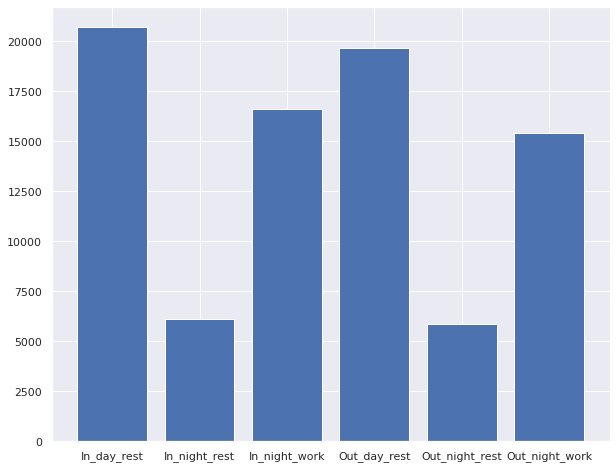

In [28]:
array=[]

#Посчитаем суммарное кол-во входящих и исходящих звонков в разное время суток
#от других операторов

array.append(df_final['voice_omo_in_day_rest_count_m3'].sum())
array.append(df_final['voice_omo_in_night_rest_count_m3'].sum())
array.append(df_final['voice_omo_in_night_work_count_m3'].sum())
array.append(df_final['voice_omo_out_day_rest_count_m3'].sum())
array.append(df_final['voice_omo_out_night_rest_count_m3'].sum())
array.append(df_final['voice_omo_out_night_work_count_m3'].sum())

array1=['In_day_rest','In_night_rest', 'In_night_work', 'Out_day_rest', 'Out_night_rest', 'Out_night_work'] 

fig=plt.figure()
fig,ax=plt.subplots()
ax.bar(array1,array)
plt.show()

Как видим, наибольшее количество звонков приходится на дневное время выходных дней и вечернее время рабочих.

Посмотрим как связаны общая стоимость всех услуг оператора с, например, количеством исходящих смс

In [29]:
from scipy.stats import pearsonr, spearmanr, kendalltau
r = pearsonr(df_final['all_cost_m3'], df_final['sms_out_count_m2'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

# взаимосвязь между стоимостью услуг оператора и кол-вом исходящих смс
#статистически значима, т.к. p-value < 0.05.

Pearson correlation: 0.17283226035914717 p-value: 6.661570016478679e-68


Посмотрим взаимосвязь между общей стоимостью услуг и продолжительностью исходящих звонков

In [30]:
from scipy.stats import pearsonr, spearmanr, kendalltau
r = pearsonr(df_final['all_cost_m3'], df_final['voice_omo_out_dur_m1'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

# с взаимосвязью между общей стоимостью услуг и кол-вом исходящих
# звонков, ситуация аналогична

Pearson correlation: 0.2779972944340726 p-value: 6.8571458591028585e-177


Теперь, получив некоторое представление о датасете и поставленной задаче, можно переходить к построению моделей

In [31]:
#Отделим tagret от основной части и посмотрим что он из себя представляет
df_X = df_final.drop('target', axis=1)# не масштабированный Х
y = df_final['target']#target

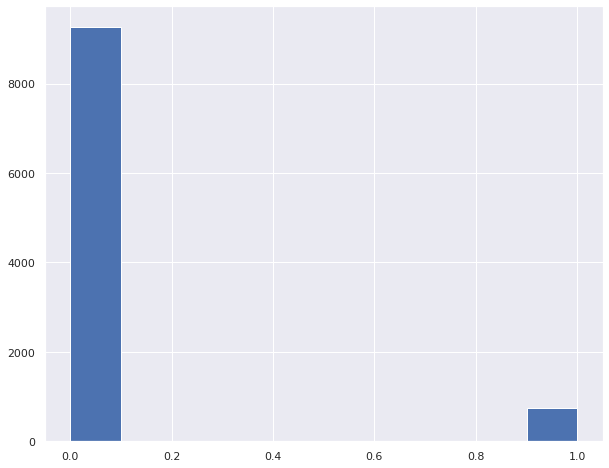

In [32]:
y.hist();#как видим классы не сбалансированы, что может сильно помешать при работе с алгоритмами

In [33]:
# X - вся таблица без таргета
# y - таргет (целевая переменная)
X = StandardScaler().fit_transform(df_final.drop(['target'], axis = 1)) # создаем Х и масштабируем данные

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
from imblearn.over_sampling import RandomOverSampler

# Искусственное добавление объектов класса 1
ros = RandomOverSampler() # метод для сбалансирования классов
X_ros, y_ros = ros.fit_resample(X_train, y_train) # перераспределяем выборку

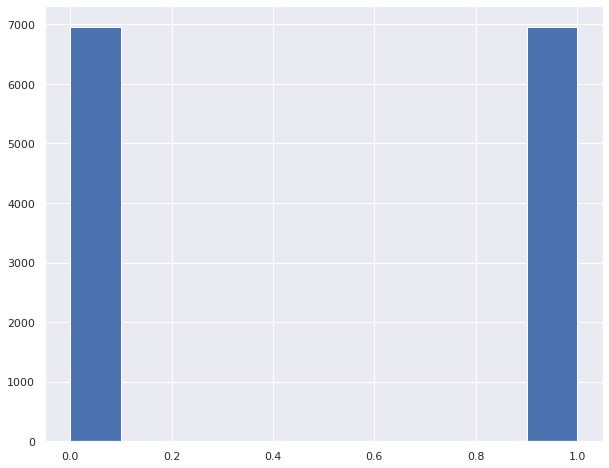

In [36]:
y_ros.hist();#как видим, теперь классы сбалансированы

# Вспомогательные функции

In [37]:
# X - вся таблица без таргета
# y - таргет (целевая переменная)
X = StandardScaler().fit_transform(df_final.drop(['target'], axis = 1)) # создаем Х и масштабируем данные

In [38]:
# Разделим выборку на обучающую и валидационную (тестовую) в соотношении 7:3
# на (X_train, y_train) будем обучать модель
# на X_valid делаем предсказания (y_pred)
# сравнивая y_valid и y_pred, будем вычислять качество предсказаний (метрику качества)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 2019)
# test_size - доля исходных данных, которую оставляем для валидации
# random_state - произвольное целое число, для воспроизводимости случайных результатов

Напишем функцию оценки модели с помощью разных метрик. Для оценки будем использовать:
1. accuracy_score - метрика, которая определяет долю правильных ответов алгоритма. $Accuracy=\frac{P}{N}$, где $P$ – количество документов по которым классификатор принял правильное решение, $N$ - размер обучающей выборки.
2. precision_score - это доля ожидаемых положительных событий, которые на самом деле являются положительными $Precision=\frac{TP}{TP+FP}$, где $TP$ - количество истинных положительных сторон, $FP$ - количество ложных положительных сторон.
3. recall_score - доля положительных событий, которые мы правильно предсказали. $Recall=\frac{TP}{TP+FN}$, где $TP$ - количество истинных положительных сторон, $FN$ - количество ложных отрицательных сторон.
4. f1_score - гармоническое среднее значение запоминания и точности. Оценка f1 рассчитывается по следующей формуле: $F1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=\frac{2*(precision*recall)}{precision+recall}$.
5. roc_auc_score - площадь под ROC-кривой (кривой ошибок). $Roc Auc=\frac{1+TPR-FPR}{2}$, где  $TPR$ - процент точек класса 1 (True Positive Rate), которые верно классифицированы нашим алгоритмом, $FPR$ - это процент точек класса 0, которые неверно классифицированы нашим алгоритмом (False Positive Rate).
6. confusion_matrix - разделит наши выборки на 4 сегмента:
    Истинно положительный - фактический = 1, прогнозируемый = 1;
    Ложный положительный - фактический = 0, прогнозируемый = 1;
    Ложно отрицательный - фактический = 1, прогнозируемый = 0;
    Истинно отрицательный - фактический = 0, прогнозируемый = 0.

In [39]:
# функция для оценки результатов 
def print_results(model, X_valid, y_true, y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred)) # доля правильных ответов алгоритма
    print('Precision:', precision_score(y_true, y_pred)) # доля объектов, названных классификатором положительными и при этом действительно являющимися положительными
    print('Recall:', recall_score(y_true, y_pred)) # показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм
    print('F1 score:', f1_score(y_true, y_pred)) # среднее гармоническое precision и recall
    print('Roc Auc:', roc_auc_score(y_true, y_pred)) # площадь (Area Under Curve) под кривой ошибок
    print('Confusion_matrix:\n', confusion_matrix(y_true, y_pred)) # таблица с 4 различными комбинациями прогнозируемых и фактических значений
    plot_confusion_matrix(model, X_valid, y_true, values_format = '5g') # визуализируем оценку confusion_matrix
    plt.show() # строим таблицу

Теперь напишем функцию построения валидационной кривой.

In [40]:
# функция построения валидационной кривой
# По оси х --- значения гиперпараметров (param_***)
# По оси y --- значения метрики (mean_test_score)
def plot_validation_curve(model_grid, param_name, params = None) :
    results_df = pd.DataFrame(model_grid.cv_results_)
    if params == None :
        plt.plot(results_df['param_' + param_name], results_df['mean_test_score'])
    else :
        plt.plot(params, results_df['mean_test_score'])
    plt.xlabel(param_name) # полписываем ось Х
    plt.ylabel('Test F1 score') # подписываем ось Y
    plt.title('Validation curve') # подписываем график
    plt.show() # строим график

# KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
y_pred = knn.predict(X_valid)

In [42]:
from sklearn.model_selection import GridSearchCV

knn_params={'n_neighbors': np.arange(1, 20, 2)} # словарь параметров (ключ: набор возможных значений)

knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1) # кросс-валидация по 5 блокам
knn_grid.fit(X_ros, y_ros)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])},
             scoring='accuracy')

In [43]:
# Смотрим лучшие значения параметров
print(knn_grid.best_params_)

# Лучшая модель
print(knn_grid.best_estimator_)

{'n_neighbors': 1}
KNeighborsClassifier(n_neighbors=1)


Accuracy: 0.9713333333333334
Precision: 0.8181818181818182
Recall: 0.7641509433962265
F1 score: 0.7902439024390244
Roc Auc: 0.8756192306651146
Confusion_matrix:
 [[2752   36]
 [  50  162]]


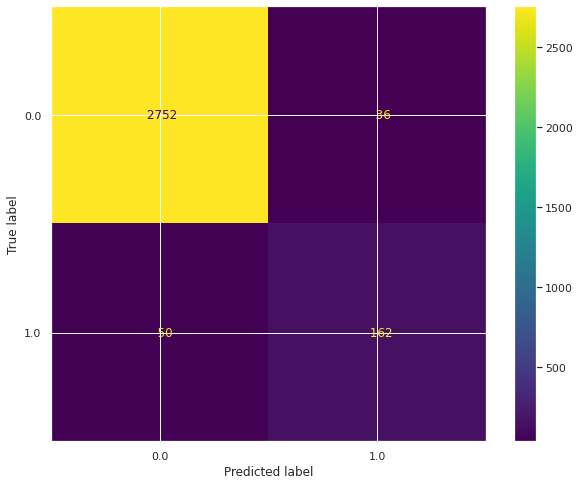

In [44]:
y_pred = knn_grid.best_estimator_.predict(X_valid) # предсказание лучшей модели
print_results(knn_grid, X_valid, y_valid, y_pred) # оценка результатов

# Деревья

In [45]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10) 
tree.fit(X_ros, y_ros) # Обучение модели (fit) на (X_train, y_train)
y_pred = tree.predict(X_valid) # Предсказание (predict) для X_valid

In [46]:
from sklearn.metrics import accuracy_score
print('Качество модели:', accuracy_score(y_valid, y_pred))

Качество модели: 0.7903333333333333


Результат весьма неплох, но посмотрим на другие метрики

Accuracy: 0.7903333333333333
Precision: 0.20256776034236804
Recall: 0.6698113207547169
F1 score: 0.31106243154435925
Roc Auc: 0.7346545843371863
Confusion_matrix:
 [[2229  559]
 [  70  142]]


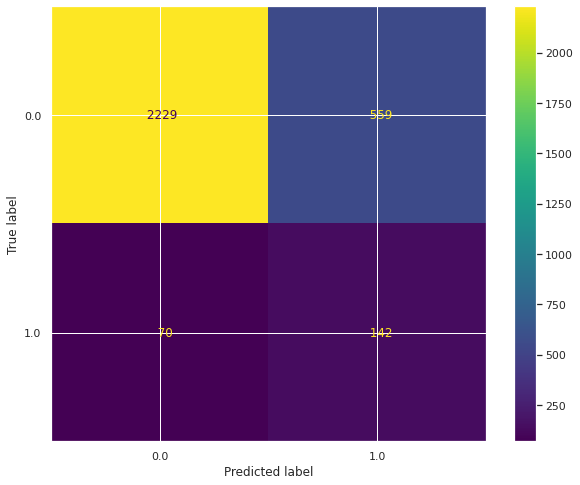

In [47]:
print_results(tree, X_valid,y_valid, y_pred )

Настройка гиперпараметров дерева

In [48]:
from sklearn.model_selection import KFold
# генератор разбиений
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

In [49]:
from sklearn.model_selection import GridSearchCV
# максимальная глубина дерева
tree_params_max_depth = {'max_depth': np.arange(2, 50)}
tree_grid_max_depth = GridSearchCV(tree, tree_params_max_depth, cv=kf, n_jobs=-1)
tree_grid_max_depth.fit(X_ros, y_ros)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=10), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [50]:
max_depth1 = tree_grid_max_depth.best_params_['max_depth']
max_depth1

49

In [51]:
tree_grid_max_depth.best_score_

0.9570563096448408

In [52]:
tree = DecisionTreeClassifier(max_depth=max_depth1)

#минимальное число обьектов для разбиения во внутренней вершине
tree_params_split = {'min_samples_split': np.arange(2, 20)}
tree_samples_split = GridSearchCV(tree, tree_params_split, cv=kf, n_jobs=-1)
tree_samples_split.fit(X_ros, y_ros)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=49), n_jobs=-1,
             param_grid={'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])})

In [53]:
min_samples_split1 = tree_samples_split.best_params_['min_samples_split']
min_samples_split1

4

In [54]:
tree_samples_split.best_score_

0.9569123471449377

In [55]:
tree = DecisionTreeClassifier(max_depth=max_depth1, min_samples_split=min_samples_split1)

# минимальное число объектов в листе
tree_params_leaf = {'min_samples_leaf': np.arange(2, 100)}
tree_samples_leaf = GridSearchCV(tree, tree_params_leaf, cv=kf, n_jobs=-1) 
tree_samples_leaf.fit(X_ros, y_ros)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=49,
                                              min_samples_split=4),
             n_jobs=-1,
             param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [56]:
min_samples_leaf1 = tree_samples_leaf.best_params_['min_samples_leaf']
min_samples_leaf1

2

In [57]:
tree_samples_leaf.best_score_

0.95216474069935

In [58]:
tree = DecisionTreeClassifier(max_depth=max_depth1, min_samples_split=min_samples_split1, min_samples_leaf=min_samples_leaf1)
tree_params_features = {'max_features': np.arange(2, 93)}
tree_max_features = GridSearchCV(tree, tree_params_features, cv=kf, n_jobs=-1) 
tree_max_features.fit(X_ros, y_ros)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=49, min_samples_leaf=2,
                                              min_samples_split=4),
             n_jobs=-1,
             param_grid={'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92])})

In [59]:
tree_max_features1 = tree_max_features.best_params_['max_features']
tree_max_features1

43

In [60]:
tree_max_features.best_score_

0.9579198776900808

Построить валидационные кривые

Text(0.5, 0, 'max_features')

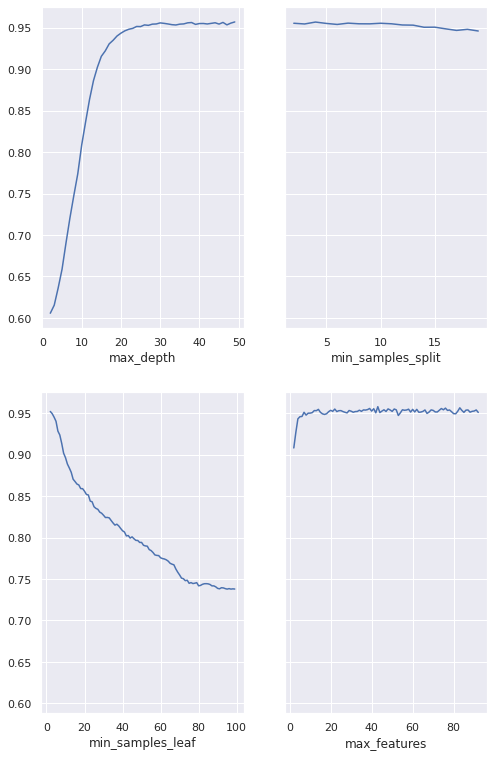

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(8,13))

ax[0, 0].plot(tree_params_max_depth['max_depth'], tree_grid_max_depth.cv_results_['mean_test_score'])
ax[0, 0].set_xlabel('max_depth')

ax[0, 1].plot(tree_params_split['min_samples_split'], tree_samples_split.cv_results_['mean_test_score'])
ax[0, 1].set_xlabel('min_samples_split')

ax[1, 0].plot(tree_params_leaf['min_samples_leaf'], tree_samples_leaf.cv_results_['mean_test_score'])
ax[1, 0].set_xlabel('min_samples_leaf')

ax[1, 1].plot(tree_params_features['max_features'], tree_max_features.cv_results_['mean_test_score'])
ax[1, 1].set_xlabel('max_features')

In [62]:
best_tree = DecisionTreeClassifier(max_depth = max_depth1, 
                                   max_features = tree_max_features1, 
                                   min_samples_leaf = min_samples_leaf1, 
                                   min_samples_split = min_samples_split1)
best_tree.fit(X_ros, y_ros)

DecisionTreeClassifier(max_depth=49, max_features=43, min_samples_leaf=2,
                       min_samples_split=4)

Наши подобранные гиперпараметры:

In [63]:
print("max_depth:", max_depth1)
print("max_features: ", tree_max_features1)
print("min_samples_leaf: ", min_samples_leaf1)
print("min_samples_split: ", min_samples_split1)

max_depth: 49
max_features:  43
min_samples_leaf:  2
min_samples_split:  4


Посмотрим к какому результату привел нас подбор гиперпараметров:

Accuracy: 0.7903333333333333
Precision: 0.20256776034236804
Recall: 0.6698113207547169
F1 score: 0.31106243154435925
Roc Auc: 0.7346545843371863
Confusion_matrix:
 [[2229  559]
 [  70  142]]


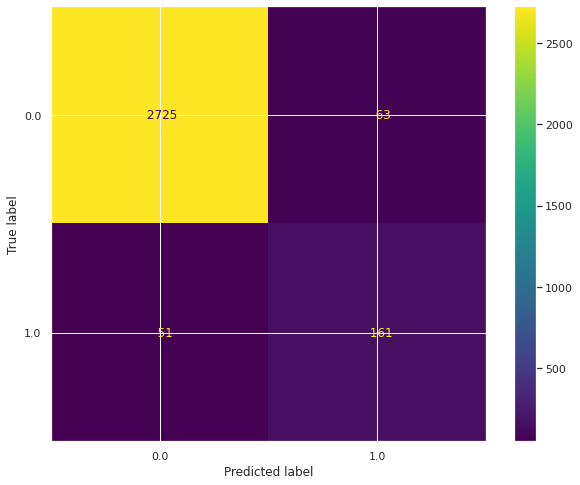

In [64]:
print_results(best_tree, X_valid, y_valid, y_pred)

In [65]:
from sklearn.tree import export_graphviz
export_graphviz(best_tree, out_file='tree.dot', feature_names=df_X.columns)
print(open('tree.dot').read()) 

digraph Tree {
node [shape=box] ;
0 [label="content_count_m3 <= 0.552\ngini = 0.5\nsamples = 13902\nvalue = [6951, 6951]"] ;
1 [label="content_cost_m1 <= -0.088\ngini = 0.493\nsamples = 10824\nvalue = [6042, 4782]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="content_count_m1 <= -0.564\ngini = 0.486\nsamples = 9450\nvalue = [5510, 3940]"] ;
1 -> 2 ;
3 [label="short_out_calls_part_m3 <= 0.129\ngini = 0.375\nsamples = 1477\nvalue = [1108, 369]"] ;
2 -> 3 ;
4 [label="all_count_m2 <= -0.37\ngini = 0.279\nsamples = 1056\nvalue = [879, 177]"] ;
3 -> 4 ;
5 [label="sms_in_count_m3 <= 0.705\ngini = 0.34\nsamples = 815\nvalue = [638, 177]"] ;
4 -> 5 ;
6 [label="data_type_2_m1 <= -0.392\ngini = 0.301\nsamples = 765\nvalue = [624, 141]"] ;
5 -> 6 ;
7 [label="data_type_3_m1 <= -0.307\ngini = 0.166\nsamples = 515\nvalue = [468, 47]"] ;
6 -> 7 ;
8 [label="gini = 0.0\nsamples = 339\nvalue = [339, 0]"] ;
7 -> 8 ;
9 [label="content_count_m1 <= -0.743\ngini = 0.391\nsamples 

Оценка важности признаков

In [66]:
features = dict(zip(range(len(df_X.columns)), df_X.columns))
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]

num = len(df_X.columns)
feature_indices = [i for i in indices[:num]]

for f in range(num):
    print(f+1, features[feature_indices[f]], importances[indices[f]])

1 content_count_m1 0.07131211511455662
2 content_count_m3 0.07064623219539176
3 data_type_3_m2 0.03254411311597247
4 all_cost_m3 0.031431720708466206
5 data_type_2_m1 0.03129371122865128
6 sms_in_count_m1 0.03107671390701649
7 data_type_3_m1 0.031013180860771605
8 sms_in_count_m3 0.02928299189454425
9 all_count_m2 0.028289072894783735
10 content_cost_m1 0.02620253471688131
11 conn_com_cost_m1 0.024938866887528218
12 short_out_calls_part_m3 0.024444410444719726
13 conn_com_cost_m3 0.023509045247455868
14 all_count_m1 0.0224245355349648
15 short_in_calls_part_m2 0.021650200575899687
16 voice_omo_out_count_m3 0.019673965532022157
17 short_in_calls_part_m1 0.018846007329486224
18 conn_com_cost_m2 0.018750198222040982
19 short_out_calls_part_m1 0.018642730184626716
20 com_num_cost_m2 0.018451428881527527
21 com_num_cost_m1 0.017981165587969042
22 all_cost_m2 0.01764485790787543
23 com_num_cost_m3 0.01689922247842814
24 paym_el_sum_m3 0.016736044738539426
25 voice_omo_out_dur_m1 0.0159439514

# Случайный лес

In [67]:
from sklearn.ensemble import RandomForestClassifier
fr = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6)
fr.fit(X_ros, y_ros)
y_pred = fr.predict(X_valid)

Accuracy: 0.855
Precision: 0.26526315789473687
Recall: 0.5943396226415094
F1 score: 0.36681222707423583
Roc Auc: 0.7345801413064075
Confusion_matrix:
 [[2439  349]
 [  86  126]]


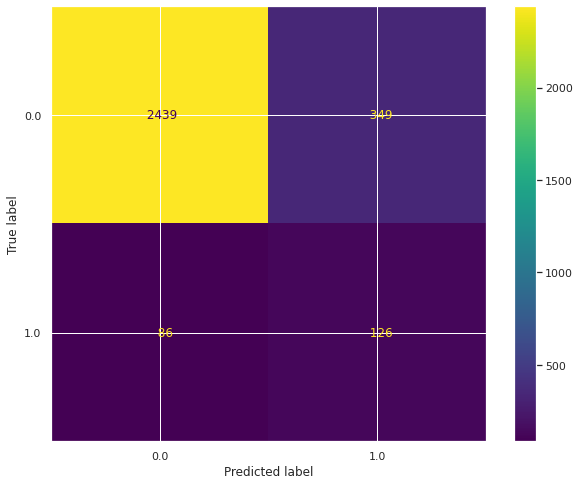

In [68]:
print_results(fr, X_valid, y_valid, y_pred)

Подбор гиперпараметров:

In [69]:
# количество деревьев 
fr_params_estimators = {'n_estimators': [20, 50, 80, 100]}
fr_n_estimators = GridSearchCV(fr, fr_params_estimators, cv=kf, n_jobs = -1)
fr_n_estimators.fit(X_ros, y_ros)
n_estimators1 = fr_n_estimators.best_params_['n_estimators']
n_estimators1

80

In [70]:
# максимальная глубина 
fr = RandomForestClassifier(n_estimators = n_estimators1)
fr_params_depth = {'max_depth': np.arange(1, 20)}
fr_max_depth = GridSearchCV(fr, fr_params_depth, cv=kf, n_jobs=-1)
fr_max_depth.fit(X_ros, y_ros)
max_depth1 = fr_max_depth.best_params_['max_depth']
max_depth1

18

In [71]:
# минимальное число объектов для разбиения во внутренней вершине min_samples_split
fr = RandomForestClassifier(n_estimators = n_estimators1, max_depth = max_depth1)
fr_params_split = {'min_samples_split': np.arange(3, 20)}
fr_samples_split = GridSearchCV(fr, fr_params_split, cv=kf, n_jobs=-1)
fr_samples_split.fit(X_ros, y_ros)
min_samples_split1 = fr_samples_split.best_params_['min_samples_split']
min_samples_split1

3

In [72]:
# минимальное число объектов в листе min_samples_leaf
fr = RandomForestClassifier(n_estimators = n_estimators1, max_depth = max_depth1)
fr_params_leaf = {'min_samples_leaf': np.arange(1, 20)}
fr_samples_leaf = GridSearchCV(fr, fr_params_leaf, cv=kf, n_jobs=-1)
fr_samples_leaf.fit(X_ros, y_ros)
min_samples_leaf1 = fr_samples_leaf.best_params_['min_samples_leaf']
min_samples_leaf1

2

In [73]:
# максимальное количество признаков, рассматриваемых при поиске лучшего разбиения
fr = RandomForestClassifier(n_estimators = n_estimators1, max_depth = max_depth1, min_samples_split = min_samples_split1, min_samples_leaf = min_samples_leaf1)
fr_params_features = {'max_features': np.arange(2, 93)}
fr_max_features = GridSearchCV(fr, fr_params_features, cv=kf, n_jobs=-1)
fr_max_features.fit(X_ros, y_ros)
max_features1 = fr_max_features.best_params_['max_features']
max_features1

7

Построим лес с нашими подобранными гиперпараметрами

In [74]:
best_forest = RandomForestClassifier(n_estimators = n_estimators1, max_depth = max_depth1, min_samples_split = min_samples_split1, min_samples_leaf = min_samples_leaf1, max_features = max_features1)
best_forest.fit(X_ros, y_ros)

RandomForestClassifier(max_depth=18, max_features=7, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=80)

In [75]:
y_pred = best_forest.predict(X_valid)

Accuracy: 0.9793333333333333
Precision: 0.987012987012987
Recall: 0.7169811320754716
F1 score: 0.8306010928961748
Roc Auc: 0.858131885980347
Confusion_matrix:
 [[2786    2]
 [  60  152]]


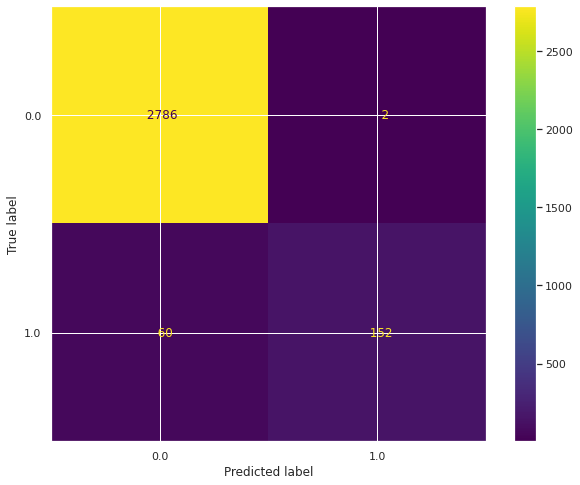

In [76]:
print_results(best_forest, X_valid, y_valid, y_pred)

Text(0.5, 0, 'max_features')

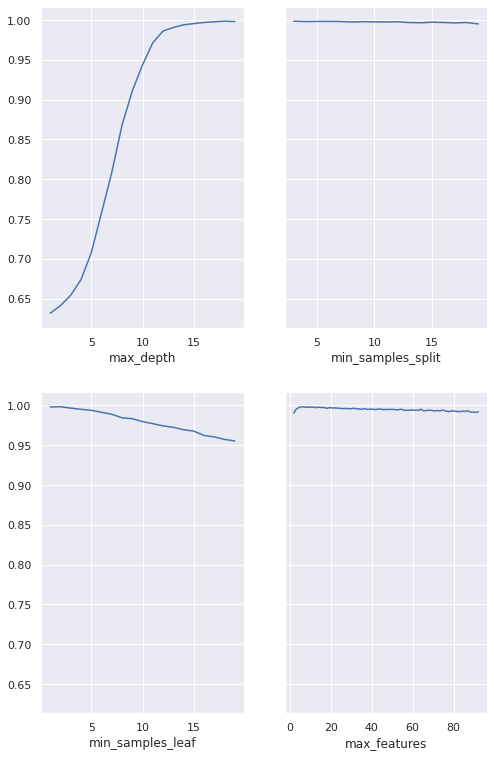

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(8,13))

ax[0, 0].plot(fr_params_depth['max_depth'], fr_max_depth.cv_results_['mean_test_score'])
ax[0, 0].set_xlabel('max_depth')

ax[0, 1].plot(fr_params_split['min_samples_split'], fr_samples_split.cv_results_['mean_test_score'])
ax[0, 1].set_xlabel('min_samples_split')

ax[1, 0].plot(fr_params_leaf['min_samples_leaf'], fr_samples_leaf.cv_results_['mean_test_score'])
ax[1, 0].set_xlabel('min_samples_leaf')

ax[1, 1].plot(fr_params_features['max_features'], fr_max_features.cv_results_['mean_test_score'])
ax[1, 1].set_xlabel('max_features')

# Logistic Regression

Перейдем к построению модели с помощью логистической регрессии. 

Логистическая регрессия - это фундаментальный метод классификации. Он принадлежит к группе линейных классификаторов. Логистическая регрессия выполняется быстро и относительно несложно. Хотя по сути это метод двоичной классификации, его также можно применить к мультиклассовым задачам.

В математической статистике логистическая регрессия (или логит-регрессия) является широко используемой статистической моделью, которая использует логистическую функцию для моделирования зависимости выходной переменной от набора входных в случае, когда первая является бинарной.

Это разновидность множественной регрессии, общее назначение которой состоит в анализе связи между несколькими независимыми переменными (называемыми также регрессорами или предикторами) и зависимой переменной. Регрессия в общем виде применяется, когда входные и выходная переменные непрерывные. А логистическая регрессия лучшим образом подходит, когда выходная переменная принимает только два значения.

Дня начала возьмем логистическую регрессию с параметром solver='liblinear'. solver — строка которая решает, какой решатель использовать для подбора модели. Есть варианты: liblinear, newton-cg, lbfgs, sag и saga. Обучим нашу модель и посмотрим точность модели с помощью accuracy_score.

In [78]:
log_reg = LogisticRegression(solver = 'liblinear') # логистическая регрессия
log_reg.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
y_pred = log_reg.predict(X_valid) # предсказание (predict) для X_valid
print(accuracy_score(y_valid, y_pred)) # оцениваем модель с помощью accuracy

0.9276666666666666


Разберёмся, так ли хороша наша модель, как кажется (accuracy=92.77 %). Для начала посмотрим на соотношение классов в задаче.

0.0    0.9261
1.0    0.0739
Name: target, dtype: float64


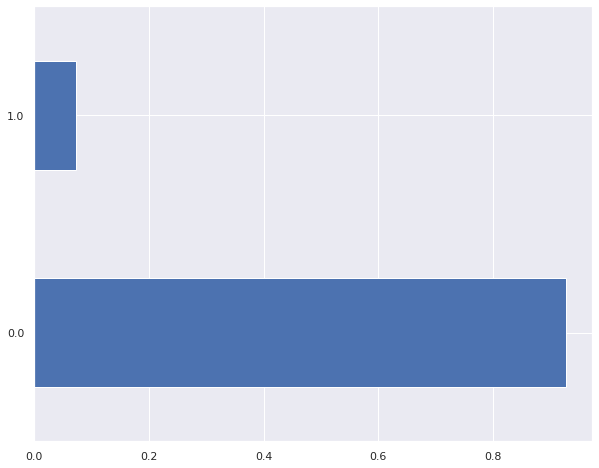

In [79]:
print(y.value_counts(normalize = True)) # выводим распределение классов
y.value_counts(normalize = True).plot(kind = 'barh') # визуализируем распределение классов
plt.show() # строим график

Мы видим, что объектов класса 0 в выборке значительно больше (92.61%), чем объектов класса 1. Из этого можно сделать вывод, что accuracy - не лучший выбор метрики качества для нашего случая, так как классы несбалансированы. Воспользуемся другими метриками для оценки построенной модели.

Accuracy: 0.9276666666666666
Precision: 0.391304347826087
Recall: 0.04245283018867924
F1 score: 0.07659574468085106
Roc Auc: 0.5187156546926179
Confusion_matrix:
 [[2774   14]
 [ 203    9]]


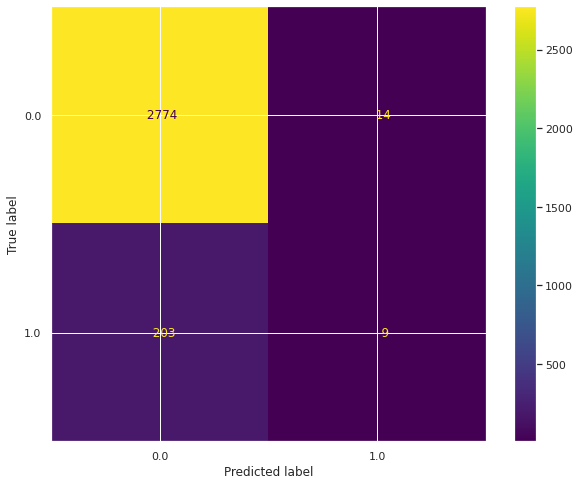

In [80]:
print_results(log_reg, X_valid, y_valid, y_pred) # выводим результаты оценки модели

Картина стала немного яснее, модель опреденно не является такой хорошей, как показала метрика accuracy. Попробуем улучшить модель, подобрав подходящие гиперпараметры.

Поэксперементируем с параметром С.

C — положительное число с плавающей запятой (1.0 по умолчанию), которое определяет относительную силу регуляризации. Меньшие значения указывают на более сильную регуляризацию

In [81]:
log_reg = LogisticRegression(solver = 'liblinear') # логистическая регрессия с гиперпараметром solver (алгоритм, использующийся для оптимизации)
C_values = {'C': np.logspace(-3, 3, 10)} # параметры для GridSearchCV
logreg_grid = GridSearchCV(log_reg, C_values, cv = 5, scoring = 'f1') # поиск лучших параметров в фиксированной сетке возможных значений
logreg_grid.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='f1')

Посмотрим, какие же параметры являются лучшими.

In [82]:
print(logreg_grid.best_params_) # лучшие параметры
print(logreg_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки

{'C': 0.46415888336127775}
0.0320374493300283


Построим валидационную кривую для параметра С.

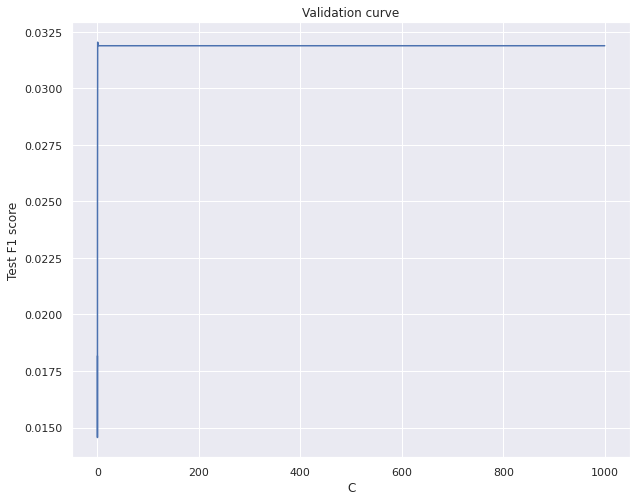

In [83]:
plot_validation_curve(logreg_grid, 'C') # строим валидационную кривую

Оценим с помощью различных метрик нашу модель.

Accuracy: 0.9273333333333333
Precision: 0.36363636363636365
Recall: 0.03773584905660377
F1 score: 0.06837606837606837
Roc Auc: 0.5163571641265803
Confusion_matrix:
 [[2774   14]
 [ 204    8]]


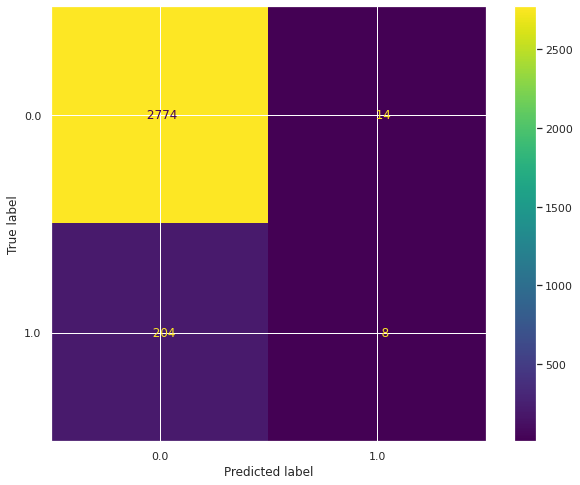

In [84]:
y_pred = logreg_grid.best_estimator_.predict(X_valid) # предсказание лучшей модели
print_results(logreg_grid, X_valid, y_valid, y_pred) # оценка результатов 

Пока что явного улучшения модели не наблюдается, попробуем добавить новый параметр penalty = 'l1'. 

penalty — строка (по умолчанию ‘l2‘), которая определяет, есть ли регуляризация и какой подход использовать. Другие варианты: l1, elasticnet и None.

In [85]:
log_reg = LogisticRegression(solver = 'liblinear', penalty = 'l1') # логистическая регрессия с гиперпараметром solver (алгоритм, использующийся для оптимизации) и регуляризацией L1 
C_values = {'C': np.logspace(-3, 3, 10)} # параметры для GridSearchCV
logreg_grid = GridSearchCV(log_reg, C_values, cv = 5, scoring = 'f1') # поиск лучших параметров в фиксированной сетке возможных значений
logreg_grid.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='f1')

Посмотрим лучший параметр С теперь.

In [86]:
print(logreg_grid.best_params_)# лучшие параметры
print(logreg_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки

{'C': 2.154434690031882}
0.032005843767449284


Построим валидационную кривую.

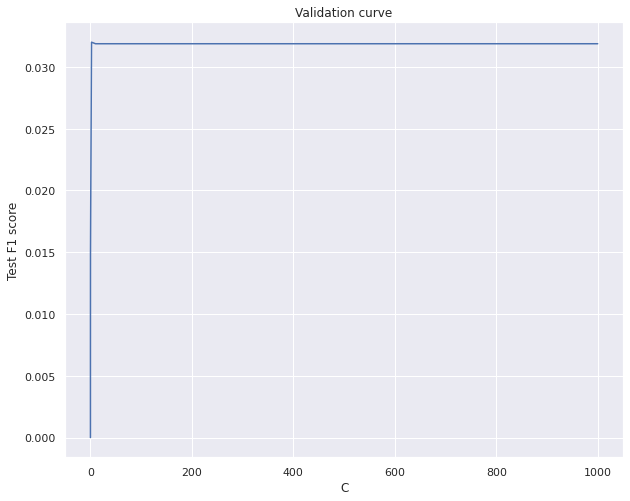

In [87]:
plot_validation_curve(logreg_grid, 'C') # строим валилационную кривую

Снова оценим модель с помощью различных метрик.

Accuracy: 0.927
Precision: 0.3333333333333333
Recall: 0.0330188679245283
F1 score: 0.060085836909871244
Roc Auc: 0.5139986735605424
Confusion_matrix:
 [[2774   14]
 [ 205    7]]


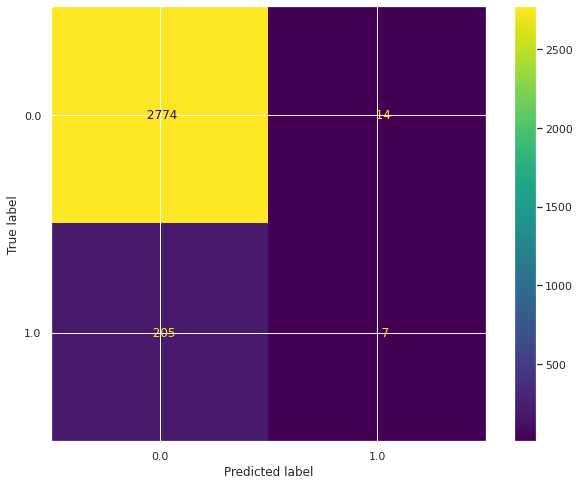

In [88]:
y_pred = logreg_grid.best_estimator_.predict(X_valid) # предсказание лучшей модели
print_results(logreg_grid, X_valid, y_valid, y_pred) # оценка результатов 

Как видим, улучшений по-прежнему нет. Попробуем улучшить нашу модель с помощью искусственного добавления объектов класса 1.

In [89]:
ros = RandomOverSampler() # метод для сбалансирования классов
X_ros, y_ros = ros.fit_resample(X_train, y_train) # перераспределяем выборку

Проверим баланс наших классов теперь.

0.0    6473
1.0    6473
Name: target, dtype: int64


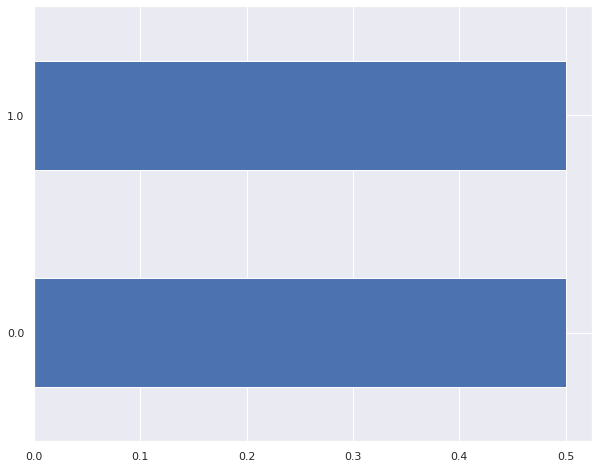

In [90]:
print(y_ros.value_counts()) # выводим количество объектов кадлого класса
y_ros.value_counts(normalize = True).plot(kind = 'barh') # визуализируем распределение
plt.show() # строим график

Как видим, теперь классы сбалансированы, попробуем обучить модель со сбалансированными классами и оценить результаты.

Accuracy: 0.706
Precision: 0.12104072398190045
Recall: 0.5047169811320755
F1 score: 0.19525547445255476
Roc Auc: 0.6130112882704853
Confusion_matrix:
 [[2011  777]
 [ 105  107]]


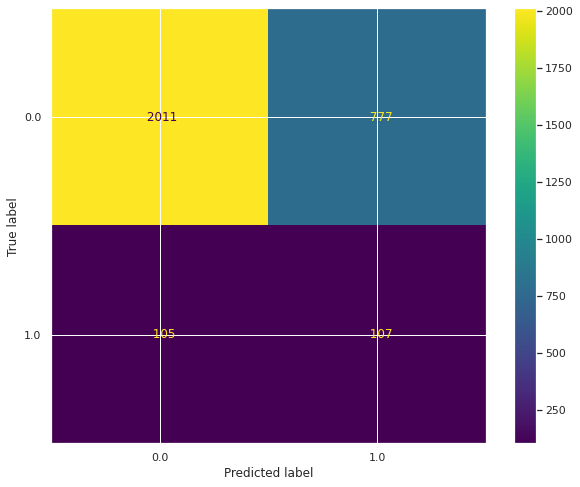

In [91]:
logreg_ros = LogisticRegression(solver = 'liblinear') # логистическая регрессия с гиперпараметром solver (алгоритм, использующийся для оптимизации)
logreg_ros.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = logreg_ros.predict(X_valid) # предсказание (predict) для X_valid
print_results(logreg_ros, X_valid, y_valid, y_pred) # оценка результатов 

Оценки большинством метрик значительно улучшились, попробуем подобрать гиперпараметры С и penalty. Посмотрим лучшие параметры и оценим качество полученной модели.

best_params:
 {'C': 0.1, 'penalty': 'l2'}
best_score:
 0.6206306440507687
Accuracy: 0.7066666666666667
Precision: 0.12045454545454545
Recall: 0.5
F1 score: 0.19413919413919412
Roc Auc: 0.6111908177905307
Confusion_matrix:
 [[2014  774]
 [ 106  106]]


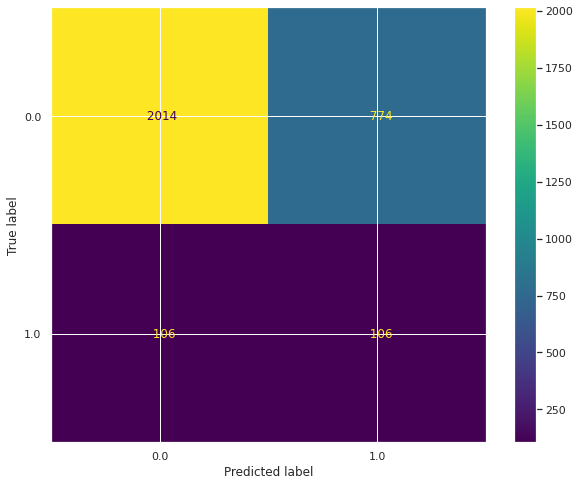

In [92]:
logreg_params = {'C': np.logspace(-3, 3, 10), 'penalty': ['l2', 'l1']} # параметры для GridSearchCV
logreg_grid = GridSearchCV(logreg_ros, logreg_params, cv = 5, scoring = 'f1') # поиск лучших параметров в фиксированной сетке возможных значений
logreg_grid.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
print("best_params:\n", logreg_grid.best_params_)# лучшие параметры
print('best_score:\n', logreg_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки
y_pred = logreg_grid.best_estimator_.predict(X_valid) # предсказание лучшей модели
print_results(logreg_grid, X_valid, y_valid, y_pred) # оценка результатов 

Модель получилось еще немного улучшить. 

Перейдем к методу опорных векторов.

# SVM

Машины опорных векторов работают, находя точки данных разных классов и рисуя границы между ними. Выбранные точки данных называются опорными векторами, а границы называются гиперплоскостями.

SVM — алгоритм обучения с учителем. Главная цель SVM как классификатора — найти уравнение разделяющей гиперплоскости
$w_1x_1+w_2x_2+…+w_nx_n+w_0=0$ в пространстве $R^n$, которая бы разделила два класса неким оптимальным образом.

После настройки весов алгоритма $w$ и $b$ (обучения), все объекты, попадающие по одну сторону от построенной гиперплоскости, будут предсказываться как первый класс, а объекты, попадающие по другую сторону — второй класс.

Обучим модель методу опорных векторов с параметрами по умолчанию и посмотрим оценки модели с помощью различных метрик качества.

Accuracy: 0.9293333333333333
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Roc Auc: 0.5
Confusion_matrix:
 [[2788    0]
 [ 212    0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


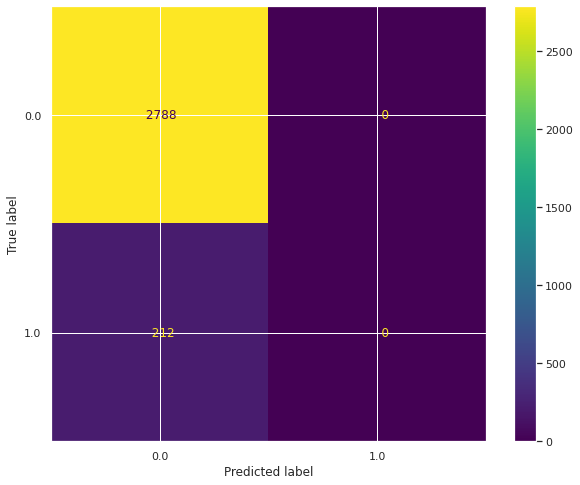

Accuracy: 0.9293333333333333
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Roc Auc: 0.5
Confusion_matrix:
 [[2788    0]
 [ 212    0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


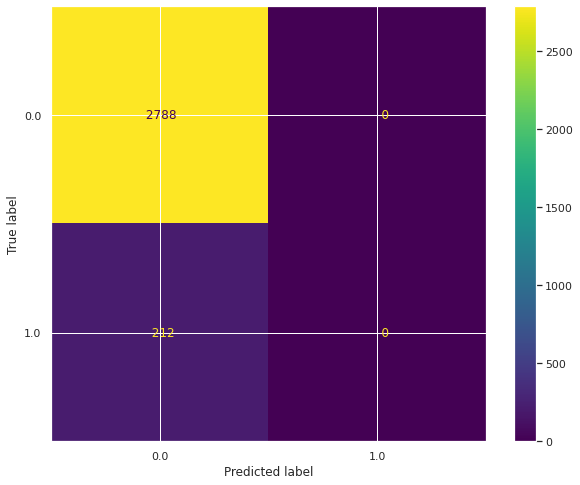

In [93]:
svm1 = svm.SVC() # метод опорных векторов
svm1.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатовsvm1 = svm.SVC() # метод опорных векторов
svm1.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатов

Получили довольно обнадеживающие результаты. Попробуем использовать метод опорных векторов на сбалансированных классах.

Accuracy: 0.8183333333333334
Precision: 0.13566739606126915
Recall: 0.29245283018867924
F1 score: 0.18535127055306427
Roc Auc: 0.5753871037600498
Confusion_matrix:
 [[2393  395]
 [ 150   62]]


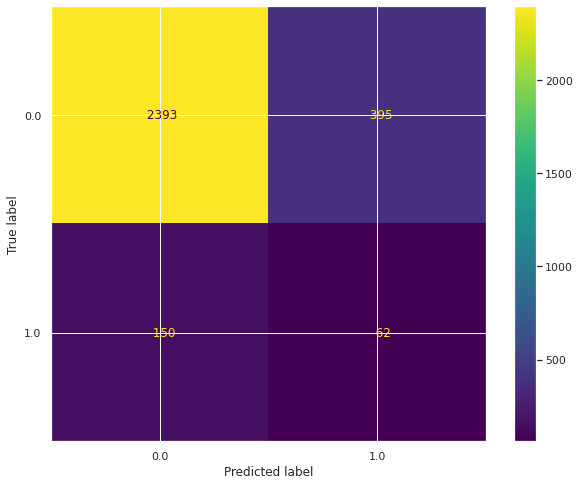

In [94]:
svm1.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатов

Результаты значительно улучшились. Поэксперементируем с параметром ядра (kernel).

Ядро - это просто функция, которая принимает две точки данных в качестве входных данных и возвращает оценку сходства. Это сходство можно интерпретировать как показатель близости. Чем ближе точки данных, тем выше сходство.

Для начала попробуем линейное ядро.

Линейные ядра вычисляют сходство во входном пространстве. Они неявно определяют трансформацию в более высокие измерения. 

Accuracy: 0.7506666666666667
Precision: 0.13387978142076504
Recall: 0.46226415094339623
F1 score: 0.2076271186440678
Roc Auc: 0.6174304972794455
Confusion_matrix:
 [[2154  634]
 [ 114   98]]


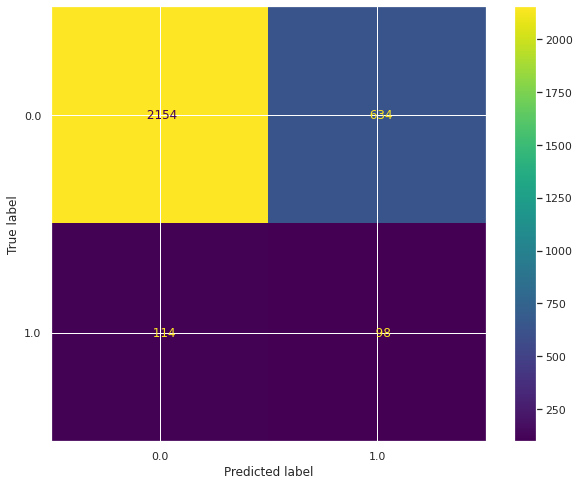

In [95]:
svm1 = svm.SVC(kernel = 'linear') # метод опорных векторов с параметром kernel  
svm1.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатов

Модель стала немного лучше.

 Попробуем теперь полиномиальное ядро. Линейные ядра являются частным случаем полиномиальных ядер, где степень = 1.

Ядро полинома позволяет нам изучать шаблоны в наших данных, как если бы у нас был доступ к функциям взаимодействия, которые являются результатом объединения ранее существующих функций

Accuracy: 0.9013333333333333
Precision: 0.18181818181818182
Recall: 0.11320754716981132
F1 score: 0.13953488372093023
Roc Auc: 0.5372350504859099
Confusion_matrix:
 [[2680  108]
 [ 188   24]]


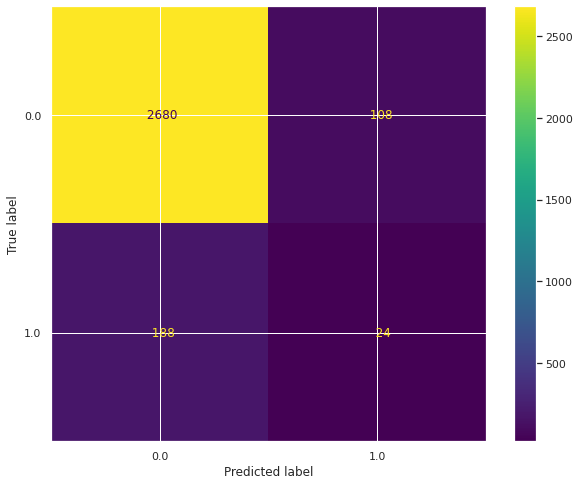

In [96]:
svm1 = svm.SVC(kernel = 'poly') 
svm1.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатов

Модель ухудшилась. С линейным ядром и ядром RBF (стоящим по умолчанию) результаты были значательно лучше.

Попробуем использовать сигмоидальное ядро.

Accuracy: 0.512
Precision: 0.07759784075573549
Recall: 0.5424528301886793
F1 score: 0.1357733175914994
Roc Auc: 0.5260685958690886
Confusion_matrix:
 [[1421 1367]
 [  97  115]]


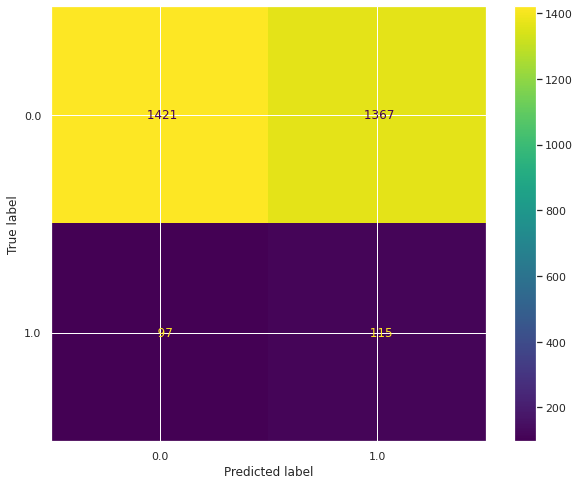

In [97]:
svm1 = svm.SVC(kernel = 'sigmoid') 
svm1.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатов

Можем сделать вывод о том, что лучше всего нам подошло линейное ядро. Поэксперементируем с другим не менее важным параметром С (параметром штрафа). 

Как правило, SVM стремятся найти гиперплоскость с максимальным запасом. То есть линия, которая имеет как можно больше места с обеих сторон.

Высокое значение C говорит алгоритму, что нам важнее правильно классифицировать все тренировочные точки, чем оставлять пространство для маневра для будущих данных. 

Accuracy: 0.928
Precision: 0.3
Recall: 0.014150943396226415
F1 score: 0.02702702702702703
Roc Auc: 0.5058200914972524
Confusion_matrix:
 [[2781    7]
 [ 209    3]]


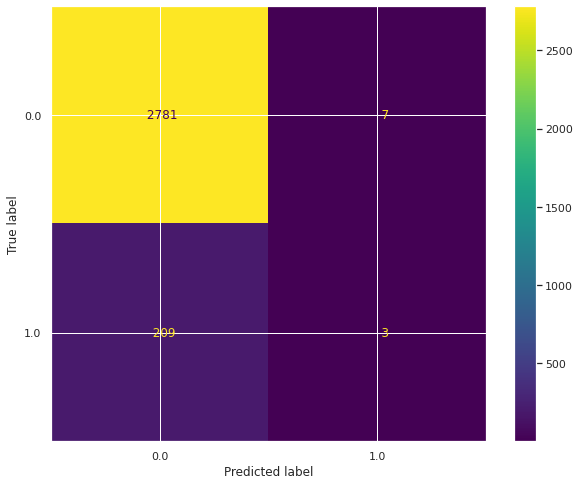

In [98]:
svm1 = svm.SVC(kernel = 'linear', C = .0000001) 
svm1.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = svm1.predict(X_valid) # предсказание (predict) для X_valid
print_results(svm1, X_valid, y_valid, y_pred) # оценка результатов

Пока результаты не слишком хорошие.

Accuracy: 0.7623333333333333
Precision: 0.13748191027496381
Recall: 0.4481132075471698
F1 score: 0.2104097452934662
Roc Auc: 0.6171699466717198
Confusion_matrix:
 [[2192  596]
 [ 117   95]]


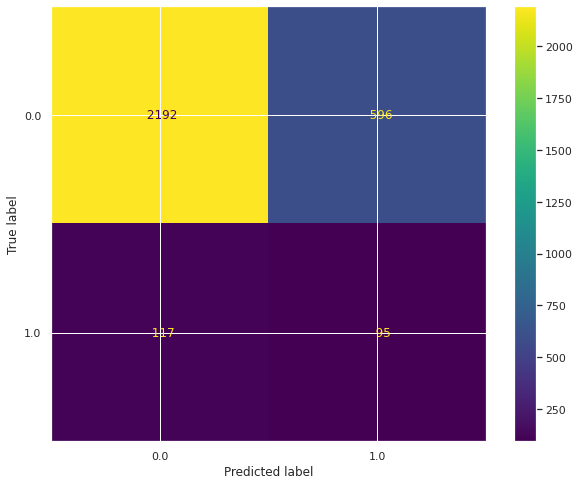

In [99]:
clf = svm.SVC(kernel = 'linear', C = 0.01) 
clf.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = clf.predict(X_valid) # предсказание (predict) для X_valid
print_results(clf, X_valid, y_valid, y_pred) # оценка результатов

Получили пока что лучшую модель с методом опорных векторов. Попробуем еще одно значение штрафа.

Accuracy: 0.782
Precision: 0.1388888888888889
Recall: 0.4009433962264151
F1 score: 0.2063106796116505
Roc Auc: 0.6059595029912563
Confusion_matrix:
 [[2261  527]
 [ 127   85]]


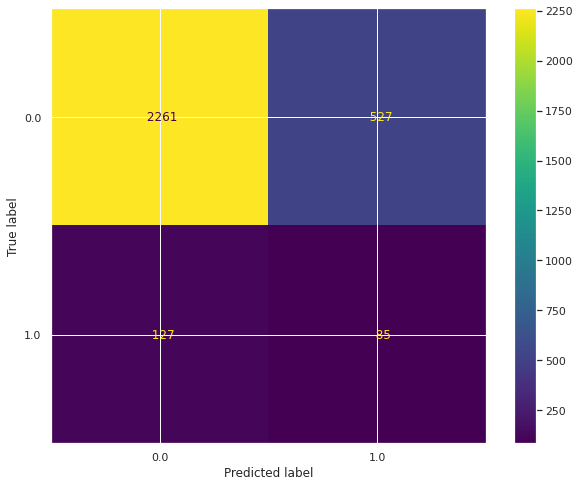

In [100]:
clf = svm.SVC(kernel = 'linear', C = 0.001) 
clf.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train
y_pred = clf.predict(X_valid) # предсказание (predict) для X_valid
print_results(clf, X_valid, y_valid, y_pred) # оценка результатов

Нам удалось улучшить модель еще сильнее.

Перейдем к нейронным сетям.

# Neural Nets

Многослойный персептрон (MLP) - это алгоритм обучения с учителем, который изучает функцию $(f(\cdot):R^m\rightarrow R^o)$ путем обучения на наборе данных, где $(m )$ - количество размеры для ввода, а $(o)$ - количество измерений для вывода. Учитывая набор функций $(X = {x_1, x_2, ..., x_m})$ и цель $(y)$, он может изучить аппроксиматор нелинейной функции для классификации или регрессии. Он отличается от логистической регрессии тем, что между входным и выходным слоями может быть один или несколько нелинейных слоев, называемых скрытыми слоями.

Построим модель искусственной нейронной сети с параметрами по умолчанию.

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


n_iter: 200
Accuracy: 0.9083333333333333
Precision: 0.22123893805309736
Recall: 0.1179245283018868
F1 score: 0.15384615384615383
Roc Auc: 0.5431803416258358
Confusion_matrix:
 [[2700   88]
 [ 187   25]]


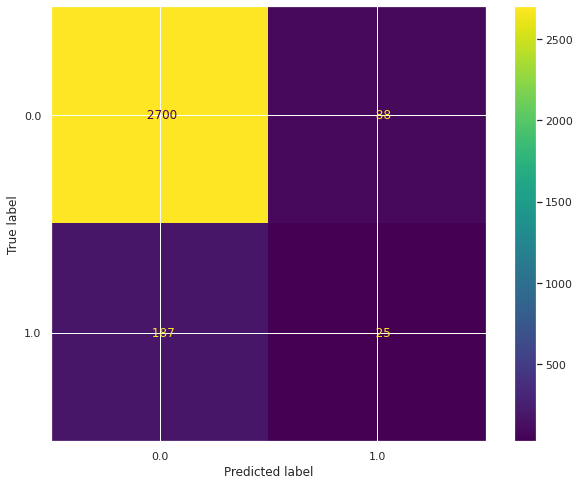

In [101]:
mlp = MLPClassifier() # модель искусственной нейронной сети
mlp.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
y_pred = mlp.predict(X_valid) # предсказание (predict) для X_valid
print("n_iter:", mlp.n_iter_) # количество итераций
print_results(mlp, X_valid, y_valid, y_pred) # оценка результатов

Попробуем усовершенствовать нашу модель, добавив параметры:
- hidden_layer_sizes представляет количество нейронов в скрытом слое;
-  max_iterint - максимальное количество итераций. Решающая программа выполняет итерацию до сходимости (определяемой параметром «tol») или до этого количества итераций.
-  alphafloat - L2 штрафной параметр (срок регуляризации).

Атрибут n_iter_int - количество итераций,которое провел решатель.

n_iter: 154
Accuracy: 0.9163333333333333
Precision: 0.21739130434782608
Recall: 0.07075471698113207
F1 score: 0.10676156583629892
Roc Auc: 0.5256929969410681
Confusion_matrix:
 [[2734   54]
 [ 197   15]]


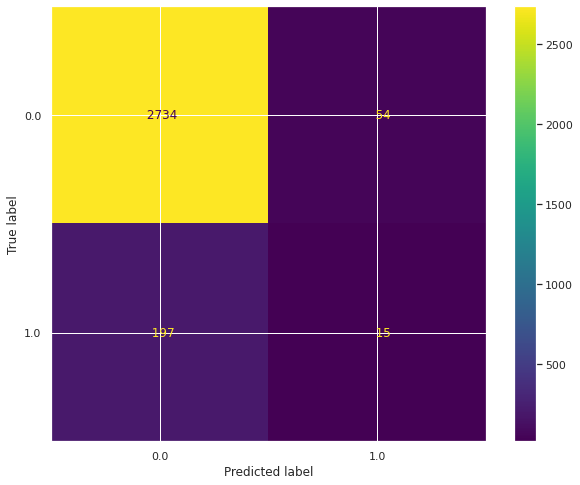

In [102]:
mlp_2 = MLPClassifier(hidden_layer_sizes = (200,), max_iter = 400, alpha = 0.1) # модель искусственной нейронной сети
mlp_2.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
y_pred = mlp_2.predict(X_valid) # предсказание (predict) для X_valid
print("n_iter:", mlp_2.n_iter_) # количество итераций
print_results(mlp_2, X_valid, y_valid, y_pred) # оценка результатов

Улучшений пока не наблюдаем. Попробуем то же самое на сбалансированных классах.

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


n_iter: 200
Accuracy: 0.883
Precision: 0.1674641148325359
Recall: 0.1650943396226415
F1 score: 0.166270783847981
Roc Auc: 0.5513420048184943
Confusion_matrix:
 [[2614  174]
 [ 177   35]]


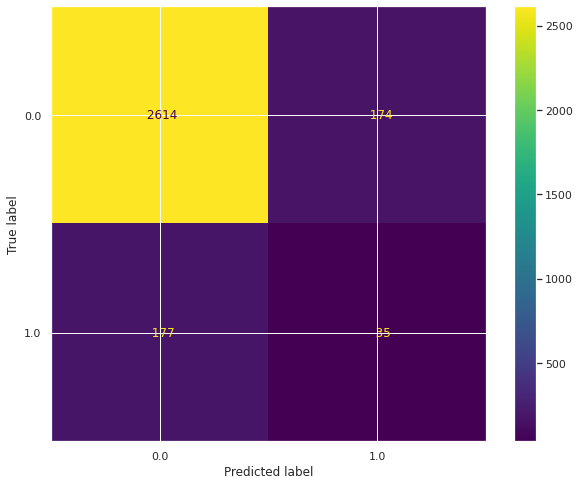

In [103]:
mlp_3 = MLPClassifier() # модель искусственной нейронной сети
mlp_3.fit(X_ros, y_ros) # обучение модели (fit) на X_ros, y_ros
y_pred = mlp_3.predict(X_valid) # предсказание (predict) для X_valid
print("n_iter:", mlp_3.n_iter_) # количество итераций
print_results(mlp_3, X_valid, y_valid, y_pred) # оценка результатов

Как видим, результаты улучшились. Поэксперементируем с параметрами.

n_iter: 72
Accuracy: 0.889
Precision: 0.19289340101522842
Recall: 0.1792452830188679
F1 score: 0.18581907090464547
Roc Auc: 0.5611075769470237
Confusion_matrix:
 [[2629  159]
 [ 174   38]]


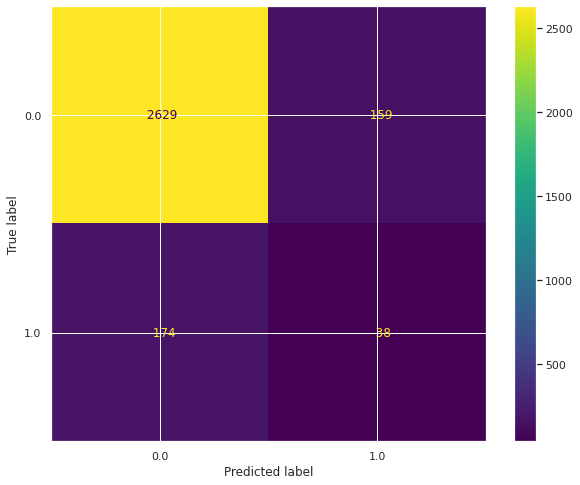

In [104]:
mlp_4 = MLPClassifier(hidden_layer_sizes = (100, 50, 20), alpha = 0.001) # модель искусственной нейронной сети
mlp_4.fit(X_ros, y_ros) # обучение модели (fit) на X_ros, y_ros
y_pred = mlp_4.predict(X_valid) # предсказание (predict) для X_valid
print("n_iter:", mlp_4.n_iter_) # количество итераций
print_results(mlp_4, X_valid, y_valid, y_pred) # оценка результатов

Улучшений нет. Попробуем использовать конвейер Pipeline, который связывает несколько преобразователей и оценщиков в единый рабочий процесс машинного обучения в нашем случае стандартизацию и наш классификатор. Для начала попробуем сделать это на несбалансированных классах.

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.914
Precision: 0.16666666666666666
Recall: 0.08247422680412371
F1 score: 0.1103448275862069
Roc Auc: 0.5269819459038437
Confusion_matrix:
 [[2726   80]
 [ 178   16]]


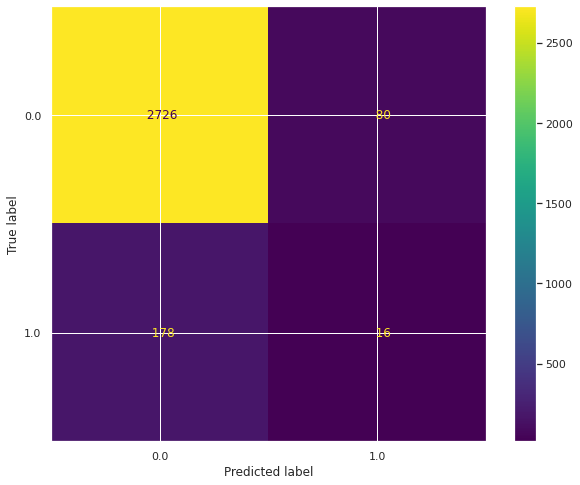

In [105]:
scaler = StandardScaler() # стандартизацция
mlp = MLPClassifier() # модель искусственной нейронной сети
model = Pipeline([('scaler', scaler), ('mlp', mlp)]) # Конвейер (Pipeline) связывает несколько преобразователей и оценщиков в единый рабочий процесс машинного обучения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # Разделим выборку на обучающую и валидационную (тестовую)
model.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
y_pred = model.predict(X_test) # предсказание (predict) для X_test
print_results(model, X_test, y_test, y_pred) # оценка результатов

Пока что оценки не слишком хорошие, подберем параметр и построим валидационную кривую.

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best (hyper)parameters: {'mlp__alpha': 0.0001}
Best score: 0.12277845159839504


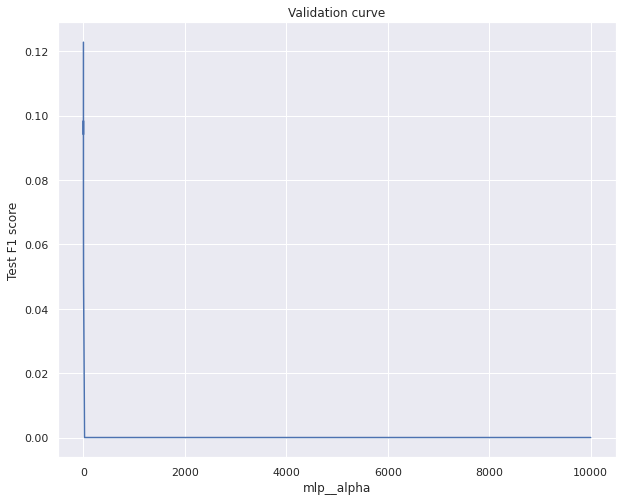

In [106]:
param_grid = {'mlp__alpha': np.logspace(-4, 4, 10)} # параметры для GridSearchCV
model_grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1', n_jobs = -1) # n_jobs=-1 задействует больше процессоров
model_grid.fit(X_train, y_train) # обучение модели (fit) на X_train, y_train
print('Best (hyper)parameters:', model_grid.best_params_) # лучшие параметры
print('Best score:', model_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки
plot_validation_curve(model_grid, 'mlp__alpha') # строим валидационную кривую

Посмотрим оценки лучшей модели.

Accuracy: 0.9143333333333333
Precision: 0.16129032258064516
Recall: 0.07731958762886598
F1 score: 0.10452961672473868
Roc Auc: 0.5247610055036703
Confusion_matrix:
 [[2728   78]
 [ 179   15]]


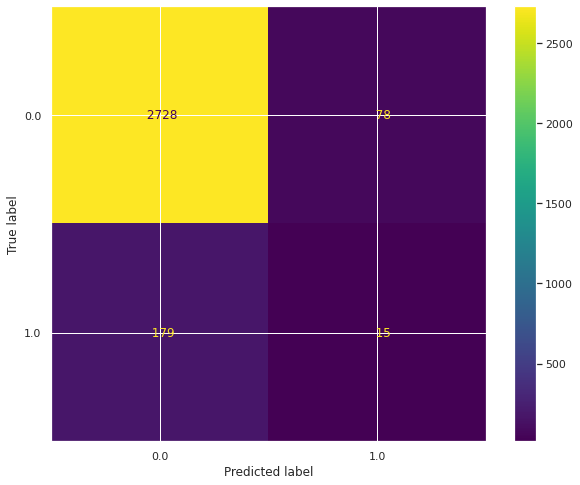

In [107]:
y_pred = model_grid.best_estimator_.predict(X_test) # предсказание (predict) для X_test
print_results(model_grid, X_test, y_test, y_pred) # оценка результатов

Результаты улучшились. Попробуем найти подходящие параметры для сбалансированных классов.

In [108]:
model_grid.fit(X_ros, y_ros) # обучение модели (fit) на X_ros, y_ros

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlp__alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring='f1')

Посмотрим лучший параметр и построим валидационную кривую.

Best (hyper)parameters: {'mlp__alpha': 0.005994842503189409}
Best score: 0.9587062047465796


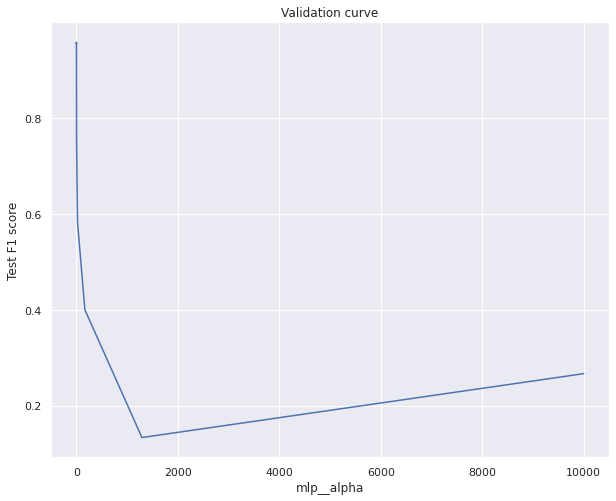

In [109]:
print('Best (hyper)parameters:', model_grid.best_params_) # лучшие параметры
print('Best score:', model_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки
plot_validation_curve(model_grid, 'mlp__alpha') # строим валидационную кривую

Оценим результат модели теперь.

Accuracy: 0.9583333333333334
Precision: 0.6589861751152074
Recall: 0.7371134020618557
F1 score: 0.6958637469586375
Roc Auc: 0.855370671095076
Confusion_matrix:
 [[2732   74]
 [  51  143]]


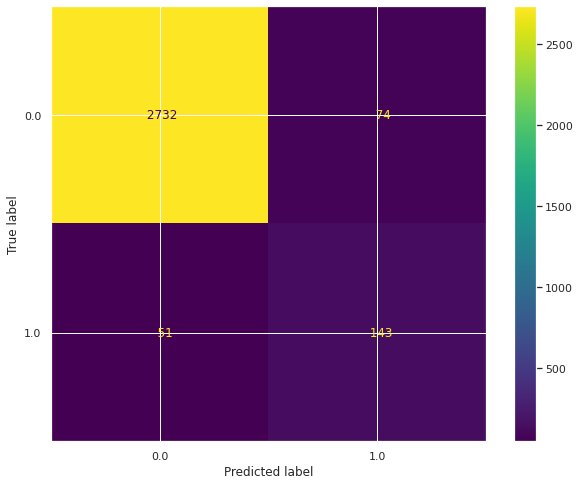

In [110]:
y_pred = model_grid.best_estimator_.predict(X_test) # предсказание (predict) для X_test
print_results(model_grid, X_test, y_test, y_pred) # оценка результатов

Получили невероятные результаты в сравнении со всеми предыдущими. Попробуем найти оптимальное значение для параметра  activation (функция активации скрытого слоя), возможные значения:

        'identity', активация без операций, полезная для реализации линейного узкого места, возвращает f (x) = x
        logistic, логистическая сигмовидная функция, возвращает f (x) = 1 / (1 + exp (-x)).
        'tanh', функция гиперболического загара, возвращает f (x) = tanh (x).
        relu, выпрямленная линейная единичная функция, возвращает f (x) = max (0, x)



In [111]:
param_grid = {'mlp__activation': ['logistic', 'tanh', 'relu']} # параметры для GridSearchCV
model_grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1', n_jobs = -1) # n_jobs=-1 задействует больше процессоров
model_grid.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['logistic', 'tanh', 'relu']},
             scoring='f1')

Посмотрим лучшее значение параметра и построим валидационную кривую.

Best (hyper)parameters: {'mlp__activation': 'relu'}
Best score: 0.9571974569283365


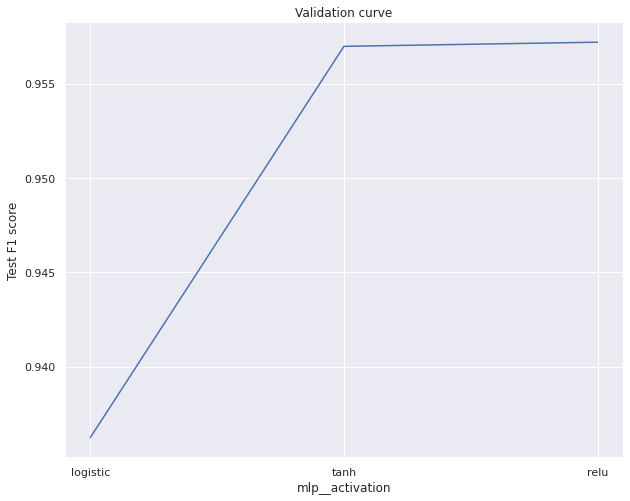

In [112]:
print('Best (hyper)parameters:', model_grid.best_params_) # лучшие параметры
print('Best score:', model_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки
plot_validation_curve(model_grid, 'mlp__activation') # строим валдационную кривую

Оценим результаты.

Accuracy: 0.962
Precision: 0.6904761904761905
Recall: 0.7474226804123711
F1 score: 0.7178217821782179
Roc Auc: 0.8621290166138834
Confusion_matrix:
 [[2741   65]
 [  49  145]]


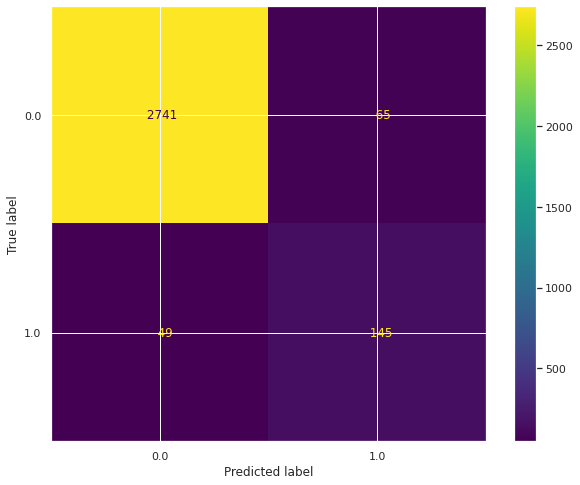

In [113]:
y_pred = model_grid.best_estimator_.predict(X_test) # предсказание (predict) для X_test
print_results(model_grid, X_test, y_test, y_pred) # оценка результатов

Модель по-прежнему дает хорошие результаты. Найдем подходящее значение для параметра hidden_layer_sizes.

In [114]:
param_grid = {'mlp__hidden_layer_sizes': [(i, ) for i in range(20, 500, 20)]} # параметры для GridSearchCV
model_grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1', n_jobs = -1) # n_jobs=-1 задействует больше процессоров
model_grid.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlp__hidden_layer_sizes': [(20,), (40,), (60,), (80,),
                                                     (100,), (120,), (140,),
                                                     (160,), (180,), (200,),
                                                     (220,), (240,), (260,),
                                                     (280,), (300,), (320,),
                                                     (340,), (360,), (380,),
                                                     (400,), (420,), (440,),
                                                     (460,), (480,)]},
             scoring='f1')

Посмотрим лучшее значение параметра и построим валидационную кривую.

Best (hyper)parameters: {'mlp__hidden_layer_sizes': (420,)}
Best score: 0.9642562839380409


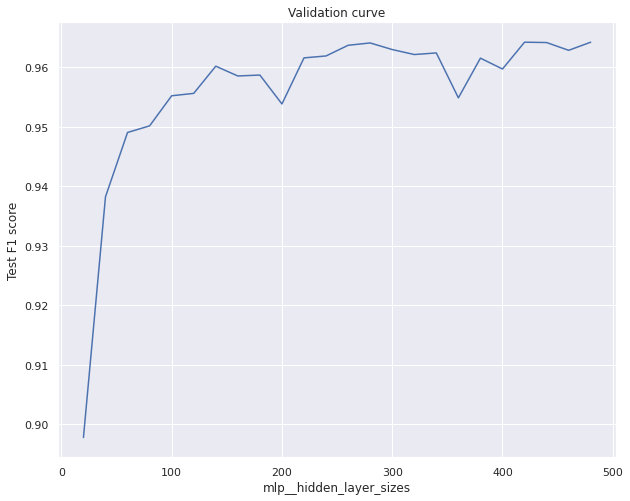

In [115]:
print('Best (hyper)parameters:', model_grid.best_params_) # лучшие параметры 
print('Best score:', model_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки
plot_validation_curve(model_grid, 'mlp__hidden_layer_sizes', [i for i in range(20, 500, 20)]) # строим валидационную кривую

Оценим полученные результаты.

Accuracy: 0.9693333333333334
Precision: 0.7741935483870968
Recall: 0.7422680412371134
F1 score: 0.7578947368421053
Roc Auc: 0.8636500576819922
Confusion_matrix:
 [[2764   42]
 [  50  144]]


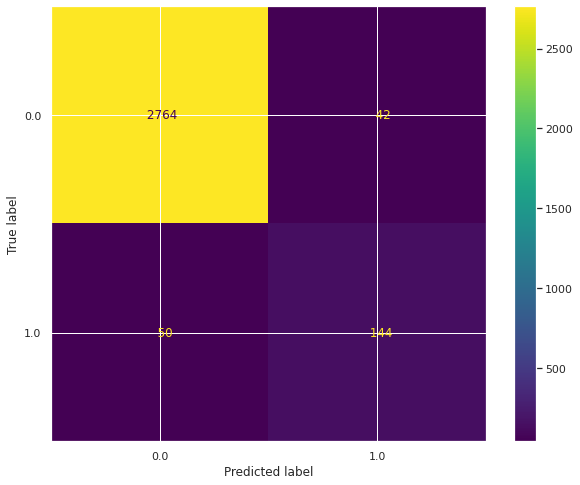

In [116]:
y_pred = model_grid.best_estimator_.predict(X_test) # предсказание (predict) для X_test
print_results(model_grid, X_test, y_test, y_pred) # оценка результатов

Получили модель еще лучше предыдущих. Подберем параметр warm_start.

In [117]:
param_grid = {'mlp__warm_start': [True, False]} # параметры для GridSearchCV
model_grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1', n_jobs = -1) # n_jobs=-1 задействует больше процессоров
model_grid.fit(X_ros, y_ros) # обучение модели (fit) на X_train, y_train

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=-1, param_grid={'mlp__warm_start': [True, False]},
             scoring='f1')

Посмотрим лучшее значение параметра и построим валидационную кривую.

Best (hyper)parameters: {'mlp__warm_start': True}
Best score: 0.959097769238603


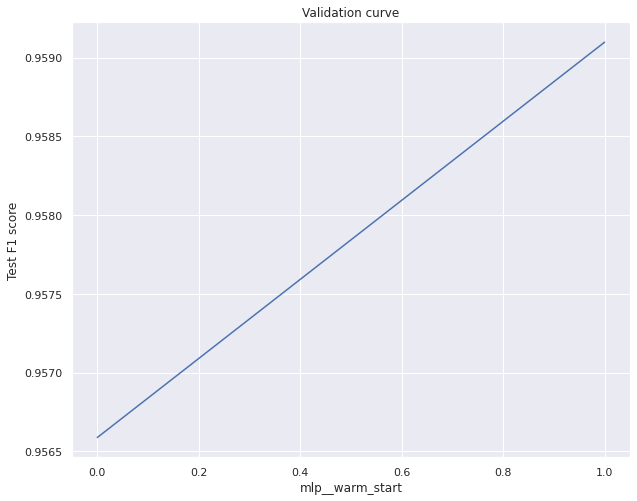

In [118]:
print('Best (hyper)parameters:', model_grid.best_params_) # лучшие параметры
print('Best score:', model_grid.best_score_) # средняя оценка перекрестной проверки лучшей оценки
plot_validation_curve(model_grid, 'mlp__warm_start') # строим валидационную кривую

Оценим результаты.

Accuracy: 0.9526666666666667
Precision: 0.6048387096774194
Recall: 0.7731958762886598
F1 score: 0.6787330316742082
Roc Auc: 0.8691353579590128
Confusion_matrix:
 [[2708   98]
 [  44  150]]


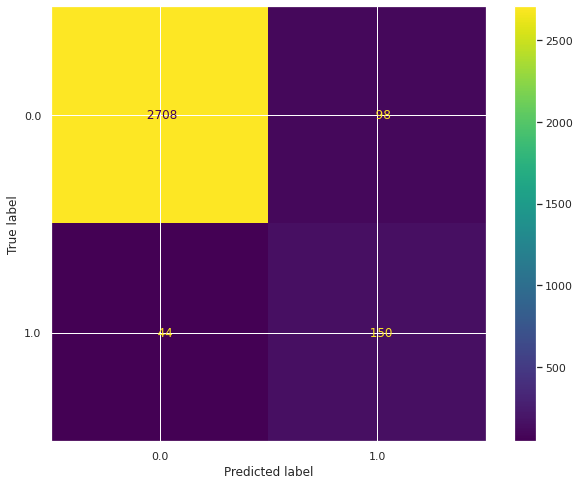

In [119]:
y_pred = model_grid.best_estimator_.predict(X_test) # предсказание (predict) для X_test
print_results(model_grid, X_test, y_test, y_pred) # оценка результатов

Опять же получили неплохие результаты.